In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [184]:
# 日付毎の24時の台数のテーブルを作る
# station_id            ステーションID
# date                  日付
# bikes_available_at0   0時の自転車台数
def get_bikes_available_at0(status):
    bikes_available_at0 = status.groupby(['station_id', 'date']).first()['bikes_available'].reset_index()
    bikes_available_at0.columns = ['station_id', 'date', 'bikes_available_at0']
    return bikes_available_at0

# 0時の自転車台数とその差分を作成
def get_diff_available_at0(status, bikes_available_at0):
    # 0時の自転車台数もくっつける
    status = pd.merge(status, bikes_available_at0, on=['station_id', 'date'], how='left')
    # 各時刻で0時の自転車台数との差分を見る
    status['deltaAt0'] = status['bikes_available'] - status['bikes_available_at0']
    return status

#statusの取得と整形
# id            そのまま
# year          年
# month         月
# day           日
# hour          時
# station_id    ステーションID
# bikes_available    利用可能な自転車台数
# predict       予測対象かどうか
# date          yyyy-mm-dd
# date_hour     yyyy-mm-dd-hh ※mergeとか整列に便利！ 
# weekday       曜日[0:月曜日・・・6:日曜日]
def get_status(filename):
    status = pd.read_csv(filename)
    status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str)
    status['date'] = pd.to_datetime(status['date'])
    status['date_hour'] = status['date'].astype(str) + '-' + status['hour'].astype(str).str.zfill(2).astype(str)
    status['weekday'] = status['date'].dt.weekday

    # 当日0時のデータを取得して、マージ。ついでに0時との台数の差分を追加。
    bikes_available_at0 = get_bikes_available_at0(status)
    status = get_diff_available_at0(status, bikes_available_at0)

    # 1時間前の利用可能台数
    status['pre_bikes_available'] = status['bikes_available'].shift(1)
    # 1時間前の利用可能台数との差分
    status['diff_bikes_available'] = status['bikes_available'] - status['pre_bikes_available']
    #status = status[status['date_hour'] != '2013-09-01-00']

    return status

# stationとcityの関連テーブルを作る
def get_station(filename):
    station = pd.read_csv(filename)
    station = station[['station_id', 'city']]
    return station

#tripの取得と整形
# trip_id           そのまま
# duration          移動時間
# start_date        yyyy-mm-dd hh:mm:ss 出発日
# start_station_id  出発ステーションID
# end_date          yyyy-mm-dd hh:mm:ss 到着日
# end_station_id    到着ステーションID
# bike_id           自転車のID
# subscription_type 利用タイプ 
# start_hour        h 出発時間
# start_day         yyyy-mm-dd 出発日
# end_hour          h 到着時間
# end_day           yyyy-mm-dd 到着日
# start_date_hour   yyyy-mm-dd-hh 出発時刻
# end_date_hour     yyyy-mm-dd-hh 到着時刻
def get_trip(filename):
    trip = pd.read_csv(filename)
    # datetime型に変換
    trip['start_date'] = pd.to_datetime(trip['start_date']) + datetime.timedelta(hours=1) # データを1時間ずらしておく。1時間前の到着時刻などを使うので。
    trip['end_date'] = pd.to_datetime(trip['end_date']) + datetime.timedelta(hours=1)     # データを1時間ずらしておく。1時間前の到着時刻などを使うので。
    trip['start_hour'] = trip['start_date'].dt.hour
    trip['start_day'] = pd.to_datetime(trip['start_date'].dt.date)
    trip['end_hour'] = trip['end_date'].dt.hour
    trip['end_day'] = pd.to_datetime(trip['end_date'].dt.date)
    trip = trip[trip['start_day'] >= '2013-09-01']
    trip = trip[trip['end_day'] >= '2013-09-01']
    trip['start_date_hour'] = trip['start_day'].astype(str) + '-' + trip['start_hour'].astype(str).str.zfill(2).astype(str)
    trip['end_date_hour'] = trip['end_day'].astype(str) + '-' + trip['end_hour'].astype(str).str.zfill(2).astype(str)
    return trip

def get_used(trip):
    # tripのgrouping
    df_start_id_hour = trip.groupby(['start_date_hour', 'start_station_id']).size().reset_index()
    df_start_id_hour = df_start_id_hour.rename(columns={'start_date_hour': 'date_hour', 'start_station_id': 'station_id', 0: 'start_num'})
    df_end_id_hour = trip.groupby(['end_date_hour', 'end_station_id']).size().reset_index()
    df_end_id_hour = df_end_id_hour.rename(columns={'end_date_hour': 'date_hour', 'end_station_id': 'station_id', 0: 'end_num'})

    # 出発と到着をくっつける
    df_start_end_id_hour = pd.merge(df_start_id_hour, df_end_id_hour, on=['date_hour', 'station_id'], how='outer').fillna(0)

    # 出発と到着の差分を求める
    df_start_end_id_hour['delta_num'] = df_start_end_id_hour['end_num'] - df_start_end_id_hour['start_num']
    df_start_end_id_hour['delta_num'] = df_start_end_id_hour['delta_num'].fillna(0)
    return df_start_end_id_hour

# 天気の取得
def get_weather(filename):
    weather = pd.read_csv(filename)
    weather = weather[['date', 'precipitation', 'events']] # 絞る
    weather_le = LabelEncoder()
    weather['events'] = weather_le.fit_transform(weather['events'])
    weather['date'] = pd.to_datetime(weather['date'])
    weather.fillna(0)
    #print(weather_le.classes_)
    return weather


In [185]:
#statusの取得と整形
df_status = get_status('org/status.csv')
print('---------- df_status ----------')
print(df_status.head(1))

# stationとcityの関連を取得
df_station_city = get_station('org/station.csv')
#print('---------- df_station_city ----------')
#print(df_station_city.head(1))

# 出発、到着、差分を取得する。
df_trip = get_trip('org/trip.csv')
df_used = get_used(df_trip)
#print('---------- df_used ----------')
#print(df_used.head(1))

# 天気を取得
df_weather = get_weather('org/weather.csv')
#print('---------- df_weather ----------')
#print(df_weather.head(1))


---------- df_status ----------
   id  year  month  day  hour  station_id  bikes_available  predict  \
0   0  2013      9    1     0           0             11.0        0   

        date      date_hour  weekday  bikes_available_at0  deltaAt0  \
0 2013-09-01  2013-09-01-00        6                 11.0       0.0   

   pre_bikes_available  diff_bikes_available  
0                  NaN                   NaN  


In [186]:
# statusにいろいろくっつける
df_status_merged = pd.merge(df_status, df_used, on=['date_hour', 'station_id'], how='left').sort_values(['station_id', 'date_hour'])
df_status_merged = pd.merge(df_status_merged, df_station_city, on=['station_id'], how='left')
df_status_merged = pd.merge(df_status_merged, df_weather, on=['date'], how='left')

df_status_merged.to_csv('df_status_merged.csv')
df_status_merged.head(1)

id  year  month  day  hour  station_id  bikes_available  predict  \
0   0  2013      9    1     0           0             11.0        0   
1   1  2013      9    1     1           0             11.0        0   
2   2  2013      9    1     2           0             11.0        0   
3   3  2013      9    1     3           0             11.0        0   
4   4  2013      9    1     4           0             11.0        0   

        date      date_hour  ...  bikes_available_at0  deltaAt0  \
0 2013-09-01  2013-09-01-00  ...                 11.0       0.0   
1 2013-09-01  2013-09-01-01  ...                 11.0       0.0   
2 2013-09-01  2013-09-01-02  ...                 11.0       0.0   
3 2013-09-01  2013-09-01-03  ...                 11.0       0.0   
4 2013-09-01  2013-09-01-04  ...                 11.0       0.0   

   pre_bikes_available  diff_bikes_available  start_num  end_num  delta_num  \
0                  NaN                   NaN        NaN      NaN        NaN   
1                 11.0                   0.0        NaN      NaN        NaN   
2                 11.0                   0.0        NaN      NaN        NaN   
3                 11.0                   0.0        NaN      NaN        NaN   
4                 11.0                   0.0        NaN      NaN        NaN   

    city precipitation  events  
0  city1           0.0       3  
1  city1           0.0       3  
2  city1           0.0       3  
3  city1           0.0       3  
4  city1           0.0       3  

[5 rows x 21 columns]

In [188]:
#説明変数のみに絞る
df_status_merged_for_input = df_status_merged[['station_id', 'date', 'hour', 'weekday', 'city', 'bikes_available_at0', 'deltaAt0', 'precipitation', 'bikes_available', 'predict']]
df_status_merged_for_input.head(1)

station_id       date  hour  weekday   city  bikes_available_at0  deltaAt0  \
0           0 2013-09-01     0        6  city1                 11.0       0.0   

   precipitation  bikes_available  predict  
0            0.0             11.0        0

In [200]:
# 各ステーション・曜日・時刻の出発と到着の平均値を求める
df_status_merged_inout = df_status_merged[df_status_merged['date'] < '2014-09-01']
id = 0
hour = 0
weekday = 0
data = []
for id in range(0, 70):
    for hour in range(4, 10):
        for weekday in range(0, 1):
            cond = (df_status_merged_inout['station_id'] == id) & (df_status_merged_inout['hour'] == hour) & (df_status_merged_inout['weekday'] == weekday)
            mean = df_status_merged_inout[cond].start_num.mean(numeric_only=True)
            if np.isnan(mean):
                df_status_merged_inout.loc[cond, 'mean_start_num'] = 0
            else:
                df_status_merged_inout.loc[cond, 'mean_start_num'] = mean

df_status_merged_inout.head(5)
print(data)
# 説明変数のみに絞る
#df_status_merged_for_input = df_status_merged[['station_id', 'date', 'hour', 'weekday', 'city', 'bikes_available_at0', 'deltaAt0', 'precipitation', 'bikes_available', 'predict']]
#df_status_merged_for_input.head(1)

[[0, 4, 0, 0], [0, 5, 0, 0], [0, 6, 0, 0.024390243902439025], [0, 7, 0, 0.6486486486486487], [0, 8, 0, 1.7659574468085106], [0, 9, 0, 3.326530612244898]]


C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\113389500.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_status_merged_inout.loc[cond, 'mean_start_num'] = 0


In [ ]:
# データの分析
# 0時の各駅のデータをくっつける。
# ステーションごとに相関を求める
# 相関が高い上位5ステーションを推測に加える
for i in range(0, 70):
    df_bikes_available_at0_st = df_status_merged[df_status_merged['station_id'] == i]
    df_bikes_available_at0_st = df_bikes_available_at0_st.rename(columns={'bikes_available_at0': 'bikes_available_at0_st' + str(i).zfill(2)})
    df_bikes_available_at0_st = df_bikes_available_at0_st[['date', 'bikes_available_at0_st' + str(i).zfill(2)]]
    df_status_trip = pd.merge(df_status_trip, df_bikes_available_at0_st, on=['date'], how='left')


In [187]:
#説明変数のみに絞る
df_status_merged_for_input = df_status_merged[['station_id', 'date', 'hour', 'weekday', 'city', 'bikes_available_at0', 'deltaAt0', 'precipitation', 'bikes_available', 'predict']]
df_status_merged_for_input.head(5)

# 時刻と曜日とcityをone hot encoding
col = 'hour'
encoder = ce.OneHotEncoder(cols=[col], handle_unknown='impute')
temp_ = encoder.fit_transform(df_status_merged_for_input[col])
df_status_merged_onehot = pd.concat([df_status_merged_for_input, temp_], axis=1)

col = 'weekday'
encoder = ce.OneHotEncoder(cols=[col], handle_unknown='impute')
temp_ = encoder.fit_transform(df_status_merged_for_input[col])
df_status_merged_onehot = pd.concat([df_status_merged_onehot, temp_], axis=1)

col = 'city'
encoder = ce.OneHotEncoder(cols=[col], handle_unknown='impute')
temp_ = encoder.fit_transform(df_status_merged_for_input[col])
df_status_merged_onehot = pd.concat([df_status_merged_onehot, temp_], axis=1)
#print(encoder.category_mapping)

df_status_merged_onehot.to_csv('df_status_merged_onehot.csv')
df_status_merged_onehot.head(1)



c:\Users\B007576\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\B007576\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\B007576\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


station_id       date  hour  weekday   city  bikes_available_at0  deltaAt0  \
0           0 2013-09-01     0        6  city1                 11.0       0.0   
1           0 2013-09-01     1        6  city1                 11.0       0.0   
2           0 2013-09-01     2        6  city1                 11.0       0.0   
3           0 2013-09-01     3        6  city1                 11.0       0.0   
4           0 2013-09-01     4        6  city1                 11.0       0.0   

   precipitation  bikes_available  predict  ...  weekday_3  weekday_4  \
0            0.0             11.0        0  ...          0          0   
1            0.0             11.0        0  ...          0          0   
2            0.0             11.0        0  ...          0          0   
3            0.0             11.0        0  ...          0          0   
4            0.0             11.0        0  ...          0          0   

   weekday_5  weekday_6  weekday_7  city_1  city_2  city_3  city_4  city_5  
0          0          0          0       1       0       0       0       0  
1          0          0          0       1       0       0       0       0  
2          0          0          0       1       0       0       0       0  
3          0          0          0       1       0       0       0       0  
4          0          0          0       1       0       0       0       0  

[5 rows x 46 columns]

In [162]:
input = df_status_merged_onehot[df_status_merged_onehot['date'] < '2014-09-01']
test = df_status_merged_onehot[(df_status_merged_onehot['date'] >= '2014-09-01') & (df_status_merged_onehot['predict'] == 1)]
valid2 = df_status_merged_onehot[(df_status_merged_onehot['date'] >= '2014-09-01') & (df_status_merged_onehot['predict'] == 0)]

# 一時的にstation_49だけに絞ってみる
st = 32
#input = input[input['station_id'] == st]
#valid2 = valid2[valid2['station_id'] == st]

# 一時的にciy2だけに絞ってみる
#input = input[input['city'] == 'city2']
#valid2 = valid2[valid2['city'] == 'city2']

#trainはbikes_availableがnanではないものに絞る
input = input[input['bikes_available'].notna()]
valid2 = valid2[valid2['bikes_available'].notna()]
input.columns

Index(['id', 'year', 'month', 'day', 'hour', 'station_id', 'bikes_available',
       'predict', 'date', 'date_hour', 'weekday', 'start_num', 'end_num',
       'delta_num', 'pre_bikes_available', 'city', 'bikes_available_at0',
       'precipitation', 'events', 'deltaAt0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'hour_24', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'city_1', 'city_2',
       'city_3', 'city_4', 'city_5'],
      dtype='object')

In [130]:
#trainをtrain, validに分割
train, valid = train_test_split(input, test_size=0.3)

#使用カラムを指定
input_column = [
       'station_id',
       'bikes_available_at0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_24',
       'weekday_1', 'weekday_2', 'weekday_3','weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'city_1', 'city_2', 'city_3', 'city_4', 'city_5',
       'bikes_available_at0_st37', 'bikes_available_at0_st39', 'bikes_available_at0_st67', 
       'events']

# 分析用にinputそのものも作っておく。本来不要
input_X = input[input_column]
input_y = input['deltaAt0']

#学習データ
train_X = train[input_column]
train_y = train['deltaAt0']

#validation: 学習データと分離したもの
valid_X = valid[input_column]
valid_y = valid['deltaAt0']

#validation: 2014/09/01～2015/08/31 でpredict=0のもの
valid2_X = valid2[input_column]
valid2_y = valid2['deltaAt0']

# 本番データ
test_X = test[input_column]


In [131]:
#モデリング
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100, max_depth=32, random_state=0, n_jobs=-1)
regr.fit(train_X, train_y)

#from sklearn.ensemble import GradientBoostingRegressor
#regr = GradientBoostingRegressor(n_estimators=1000, verbose=1)
#regr.fit(train_X, train_y)


      Iter       Train Loss   Remaining Time 
         1           9.2748           14.79m
         2           8.9875           14.95m
         3           8.7480           15.17m
         4           8.5522           15.07m
         5           8.3859           15.11m
         6           8.2503           14.98m
         7           8.1335           14.94m
         8           8.0346           14.89m
         9           7.9512           14.87m
        10           7.8805           14.87m
        20           7.4950           14.74m
        30           7.3290           14.49m
        40           7.2064           14.37m
        50           7.1064           14.16m
        60           7.0295           14.01m
        70           6.9619           13.87m
        80           6.9011           13.71m
        90           6.8606           13.53m
       100           6.8135           13.39m
       200           6.5212           11.76m
       300           6.2308           10.22m
       40

GradientBoostingRegressor(n_estimators=1000, verbose=1)

In [142]:
#validデータに対して予測
val_predict = regr.predict(valid_X)
# bikes_availableに戻してRMSE
val_predict = valid['bikes_available_at0'] - val_predict
print(mean_squared_error(valid['bikes_available'], val_predict, squared=False))

#valid2データに対して予測
val2_predict = regr.predict(valid2_X)
# bikes_availableに戻してRMSE
val2_predict = valid2['bikes_available_at0'] - val2_predict
print(mean_squared_error(valid2['bikes_available'], val2_predict, squared=False))

#inputデータに対して予測
input_predict = regr.predict(input_X)
# bikes_availableに戻してRMSE
input_predict = input['bikes_available_at0'] - input_predict
print(mean_squared_error(input['bikes_available'], input_predict, squared=False))

#testデータに対する予測
test_predict = regr.predict(test_X)
test_predict = test['bikes_available_at0'] - test_predict
sub_index = df_status[df_status['predict'] == 1].index
sub_df = pd.DataFrame(list(zip(sub_index, test_predict)))
sub_df.to_csv("submission.csv",index=False, header=False)

# depth = 15
#2.0493483195499724
#2.382940699117467
#1.9882235796361787
# city2
#3.009776924807749
#3.3220180642972688
#2.430454722845259

# GradientboostingRegressor city2
#3.350701680113865
#3.4953149812761763
#3.338056778020615
#3.0207594041160464
#3.170455231146837
#2.9957356312706644

# GradientboostingRegressor
#2.3796365185729873
#2.531491974272479
#2.3697719163143365


2.3796365185729873
2.531491974272479
2.3697719163143365


39765 49920
90956 109200
16974 21840
16531 21840
13234 15600


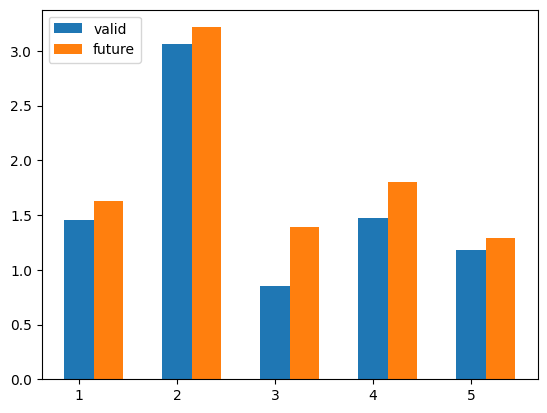

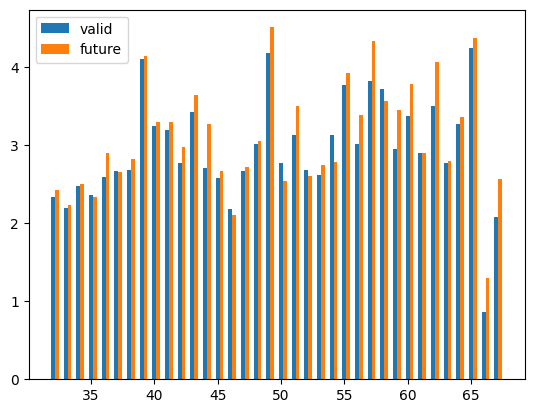

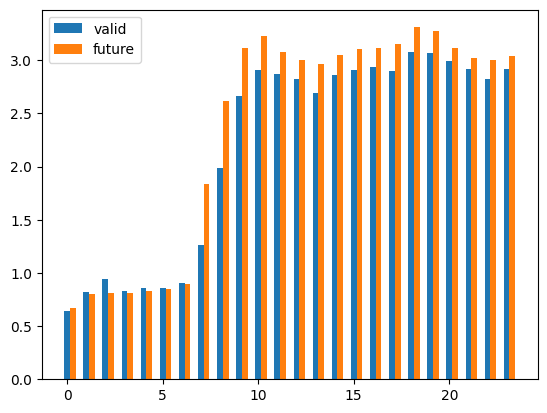

1426 8470
0 1750
18152 26250
157882 181930


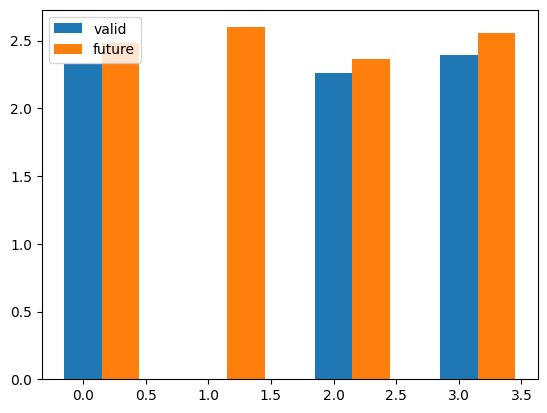

25079 36680
25266 31220
25323 39690
25547 34790
25201 28210
25274 18410
25770 29400


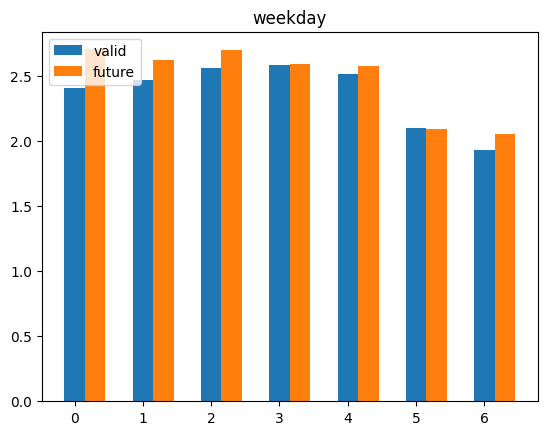

In [143]:
# valid, valid2のグラフ化
valid_predict = valid
valid_predict['bikes_available_predict'] = val_predict
valid_predict2 = valid2
valid_predict2['bikes_available_predict'] = val2_predict

# cityごとのRMSEの差分
rmse_by_city1 = []
rmse_by_city2 = []
for i in range(1, 6):
    temp1 = valid_predict[valid_predict['city'] == 'city' + str(i)]
    if len(temp1) > 0:
        rmse_by_city1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_city1.append(0)
    temp2 = valid_predict2[valid_predict2['city'] == 'city' + str(i)]
    if len(temp2) > 0:
        rmse_by_city2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_city2.append(0)
    print(len(temp1), len(temp2))
plt.bar(range(1, 6), rmse_by_city1, width=0.3, label='valid')
plt.bar(np.array(range(1, 6)) + 0.3, rmse_by_city2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# ステーションごとのRMSEの差分
rmse_by_station1 = []
rmse_by_station2 = []
for i in range(32, 68):
    temp1 = valid_predict[valid_predict['station_id'] == i]
    if len(temp1) > 0:
        rmse_by_station1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_station1.append(0)
    temp2 = valid_predict2[valid_predict2['station_id'] == i]
    if len(temp2) > 0:
        rmse_by_station2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_station2.append(0)
plt.bar(range(32, 68), rmse_by_station1, width=0.3, label='valid')
plt.bar(np.array(range(32, 68)) + 0.3, rmse_by_station2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# 時刻ごとのRMSEの差分
rmse_by_hour1 = []
rmse_by_hour2 = []
for i in range(0, 24):
    temp1 = valid_predict[valid_predict['hour'] == i]
    rmse_by_hour1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    temp2 = valid_predict2[valid_predict2['hour'] == i]
    rmse_by_hour2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
plt.bar(range(0, 24), rmse_by_hour1, width=0.3, label='valid')
plt.bar(np.array(range(0, 24)) + 0.3, rmse_by_hour2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# 天気ごとのRMSEの差分
rmse_by_events1 = []
rmse_by_events2 = []
for i in range(0, 4):
    temp1 = valid_predict[valid_predict['events'] == i]
    if len(temp1) > 0:
        rmse_by_events1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_events1.append(0)
    if len(temp2) > 0:
        temp2 = valid_predict2[valid_predict2['events'] == i]
        rmse_by_events2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_events1.append(0)
    print(len(temp1), len(temp2))
plt.bar(range(0, 4), rmse_by_events1, width=0.3, label='valid')
plt.bar(np.array(range(0, 4)) + 0.3, rmse_by_events2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# 曜日ごとのRMSEの差分
rmse_by_weekday1 = []
rmse_by_weekday2 = []
for i in range(0, 7):
    temp1 = valid_predict[valid_predict['weekday'] == i]
    if len(temp1) > 0:
        rmse_by_weekday1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_weekday1.append(0)
    if len(temp2) > 0:
        temp2 = valid_predict2[valid_predict2['weekday'] == i]
        rmse_by_weekday2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_weekday2.append(0)
    print(len(temp1), len(temp2))
plt.bar(range(0, 7), rmse_by_weekday1, width=0.3, label='valid')
plt.bar(np.array(range(0, 7)) + 0.3, rmse_by_weekday2, width=0.3, label='future')
plt.title("weekday")
plt.legend(loc=2)
plt.show()


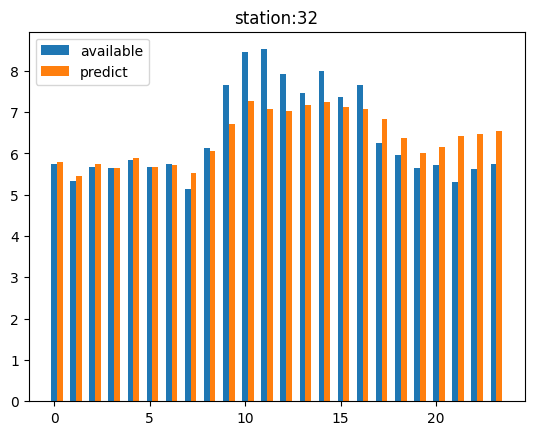

In [144]:
# ステーション、日付ごとに折れ線
for st in range(32, 33):
    target_station = valid_predict[valid_predict['station_id'] == st]
    target_station = target_station.sort_values('date_hour')

    # 時間ごとのbikes_availableの平均
    available_by_target = []
    predict_by_target = []
    for i in range(0, 24):
        temp1 = target_station[target_station['hour'] == i]
        if len(temp1) > 0:
            available_by_target.append((temp1['bikes_available']).mean())
            predict_by_target.append((temp1['bikes_available_predict']).mean())
        else:
            available_by_target.append(0)
            predict_by_target.append(0)
    plt.bar(range(0, 24), available_by_target, width=0.3, label='available')
    plt.bar(np.array(range(0, 24)) + 0.3, predict_by_target, width=0.3, label='predict')
    plt.legend(loc=2)
    plt.title("station:" + str(st))
    plt.show()


Text(0.5, 1.0, 'bikes_available Station:32')

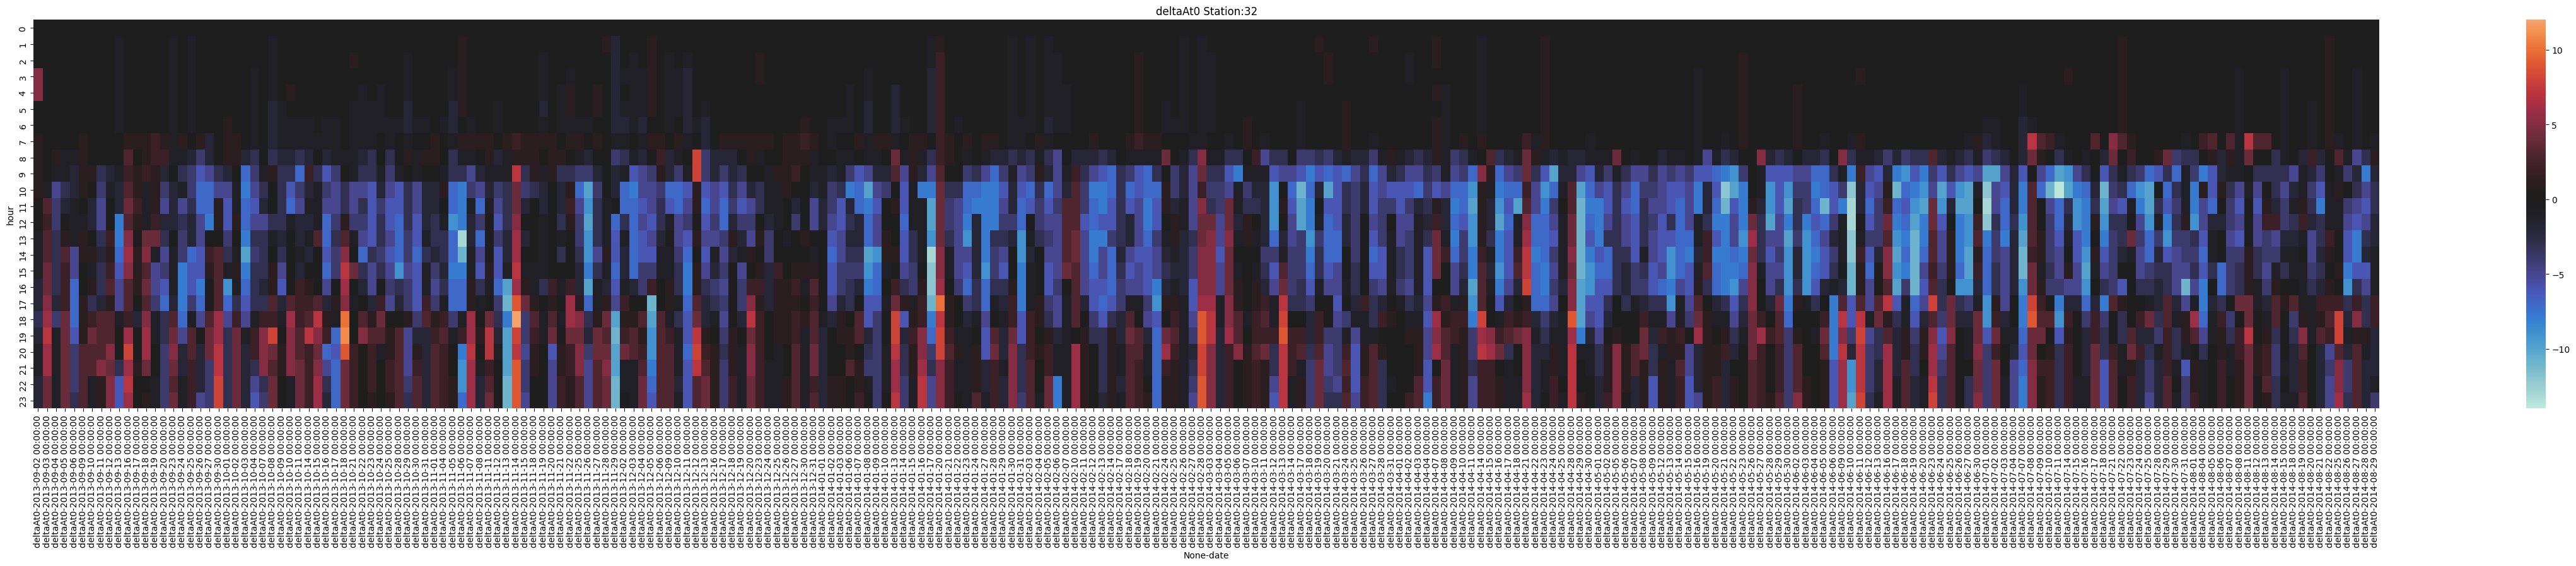

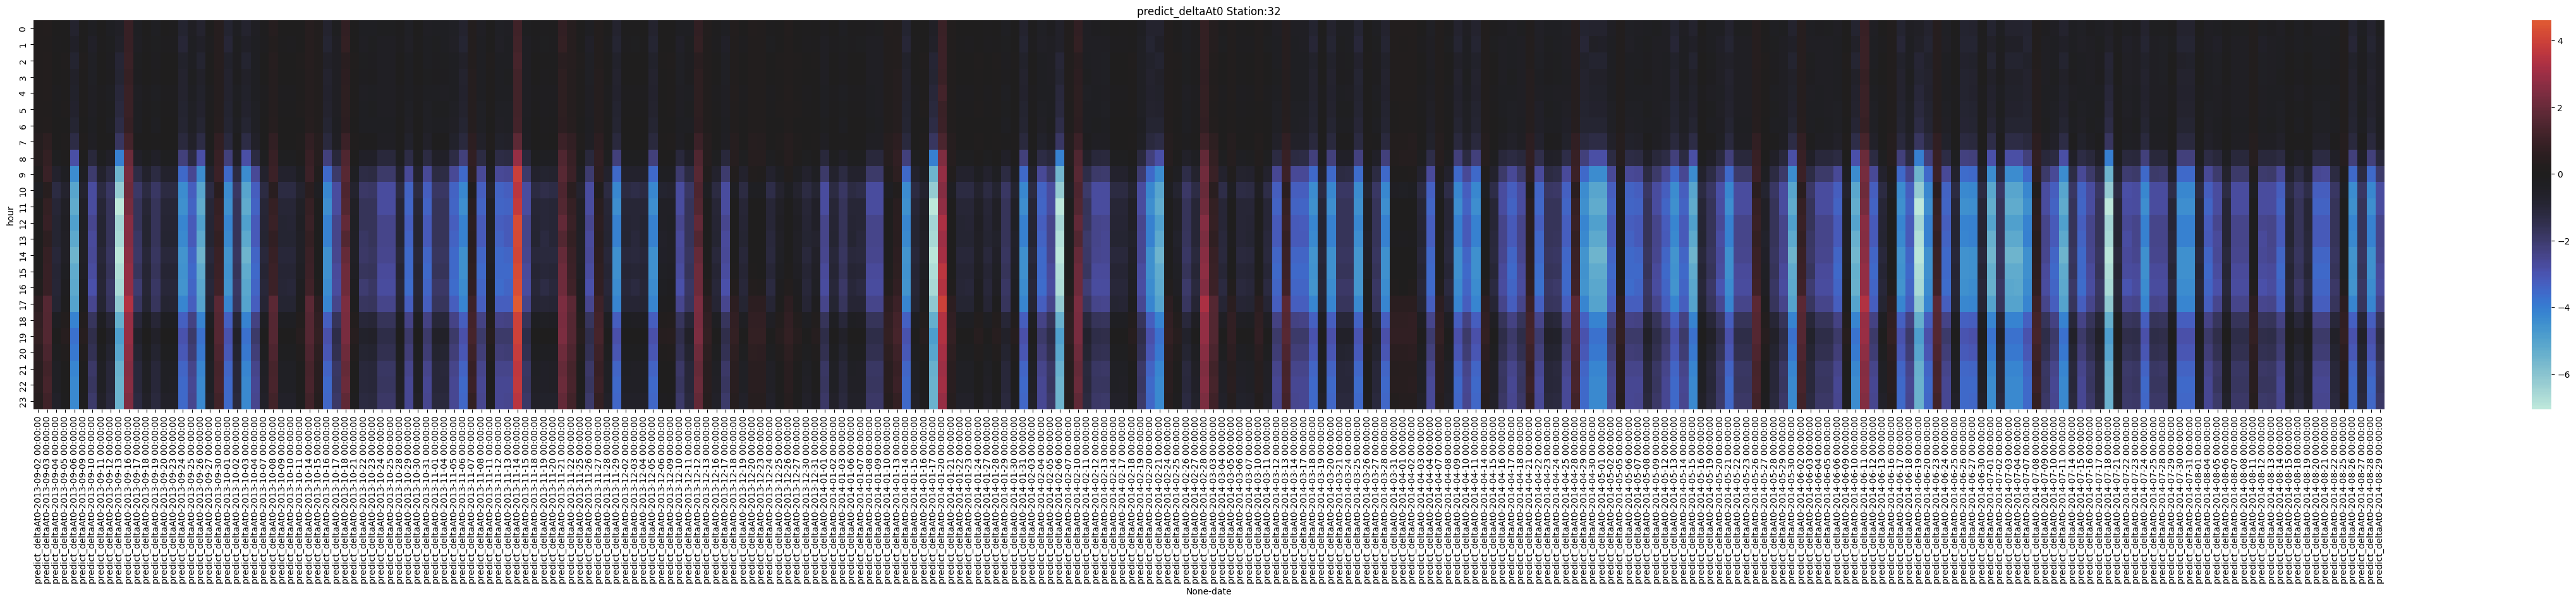

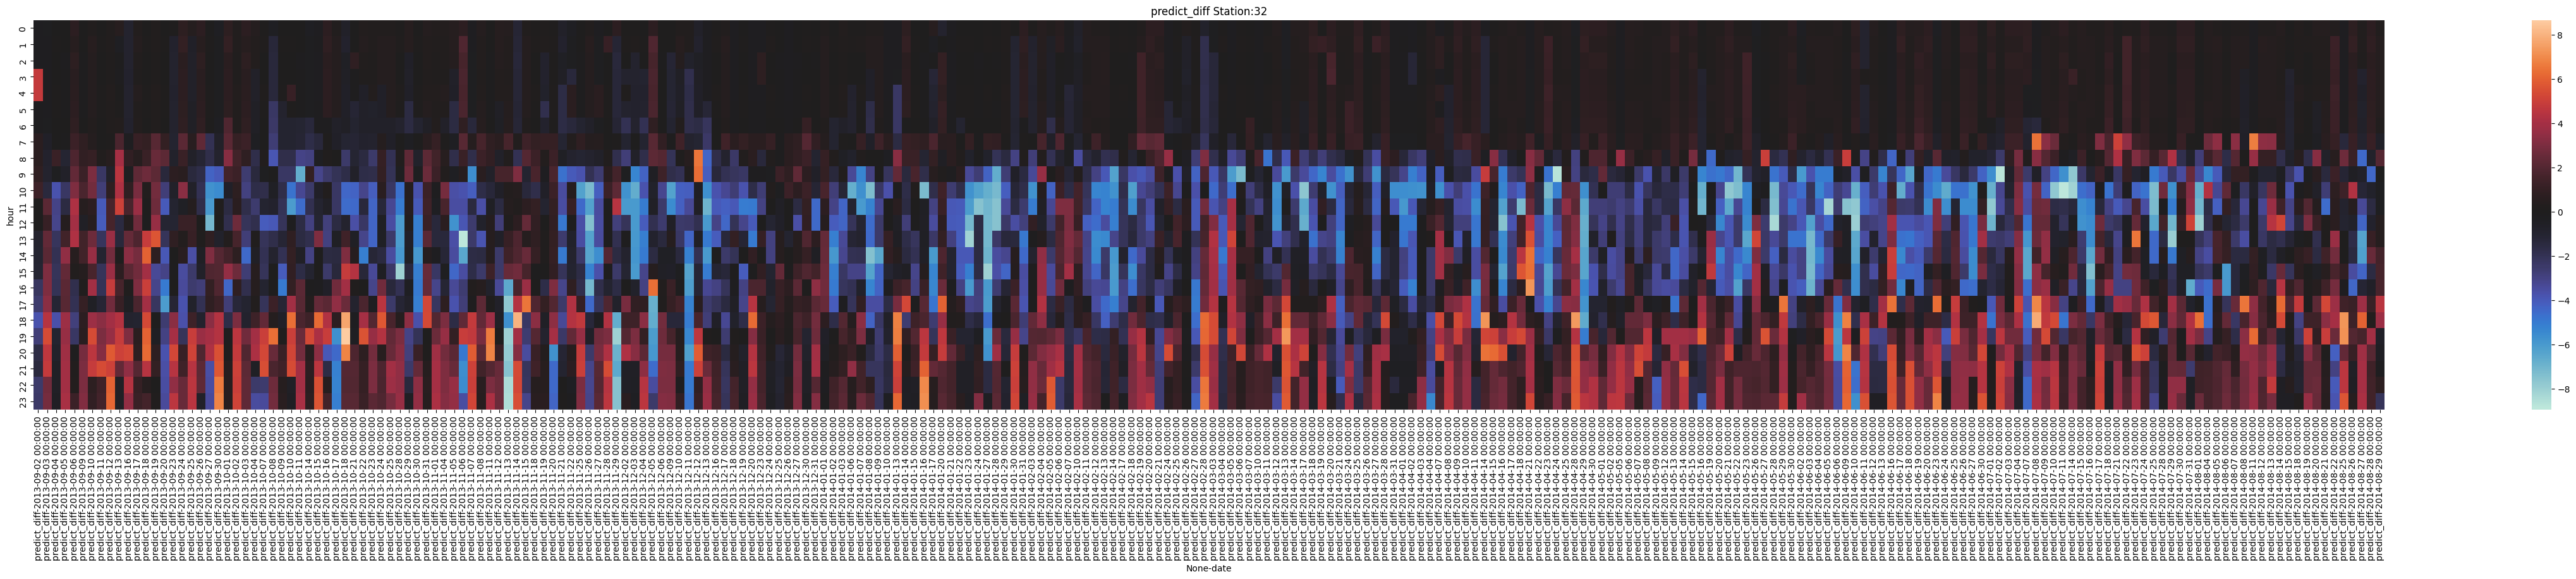

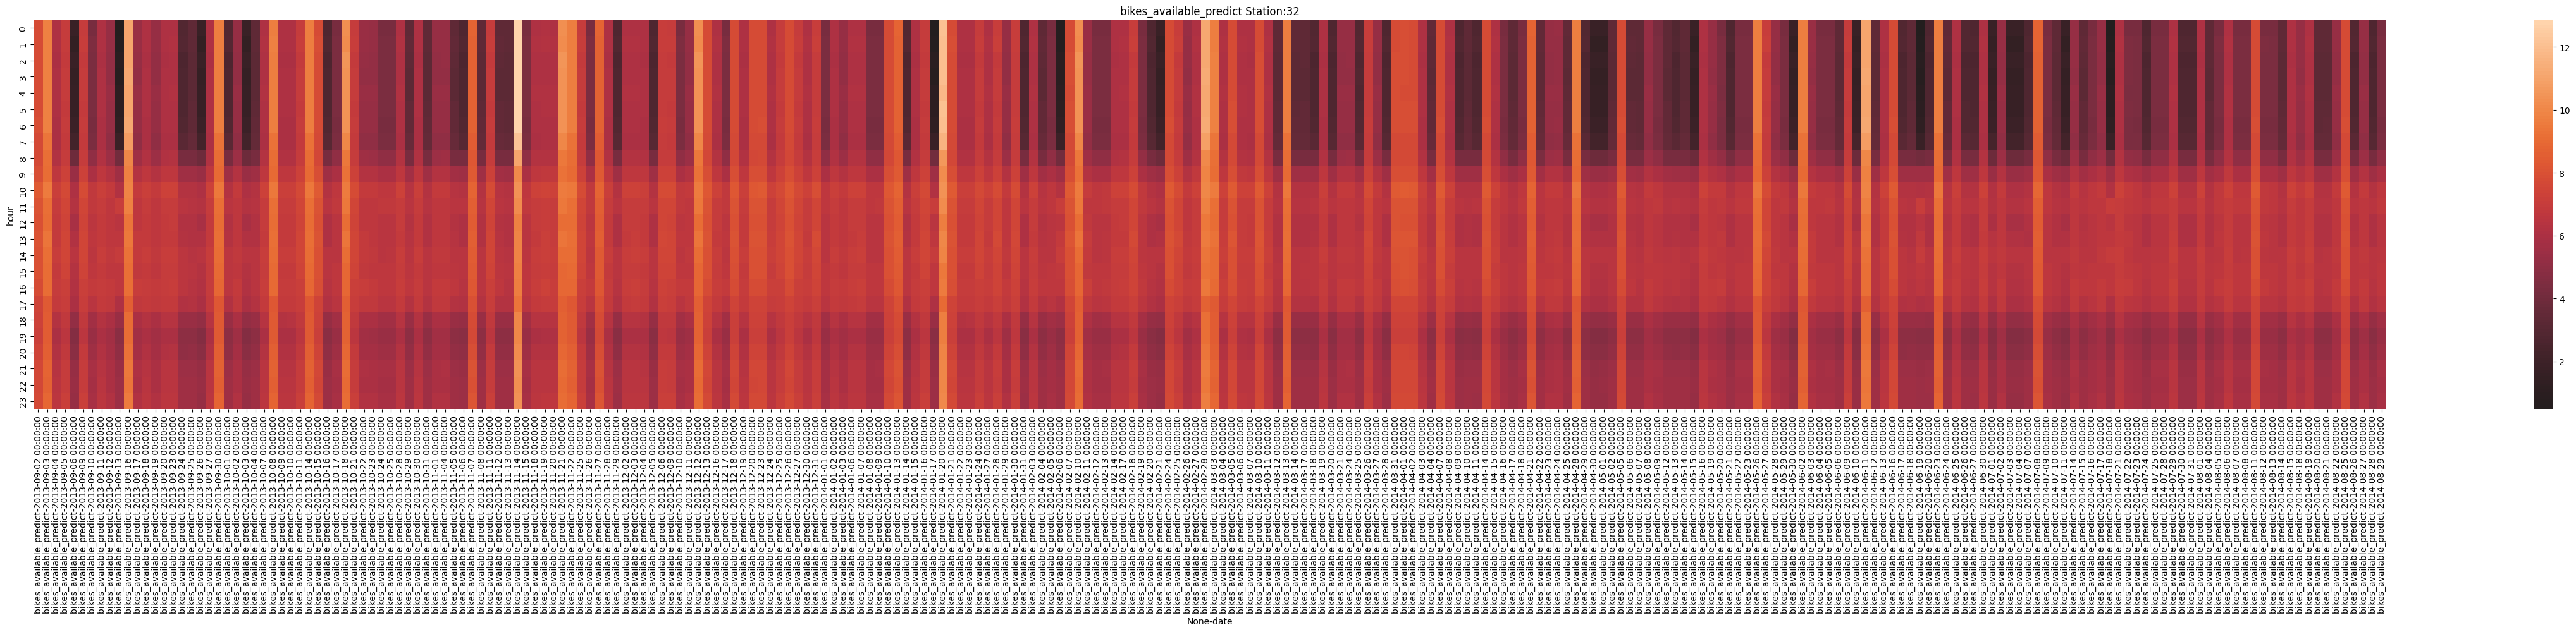

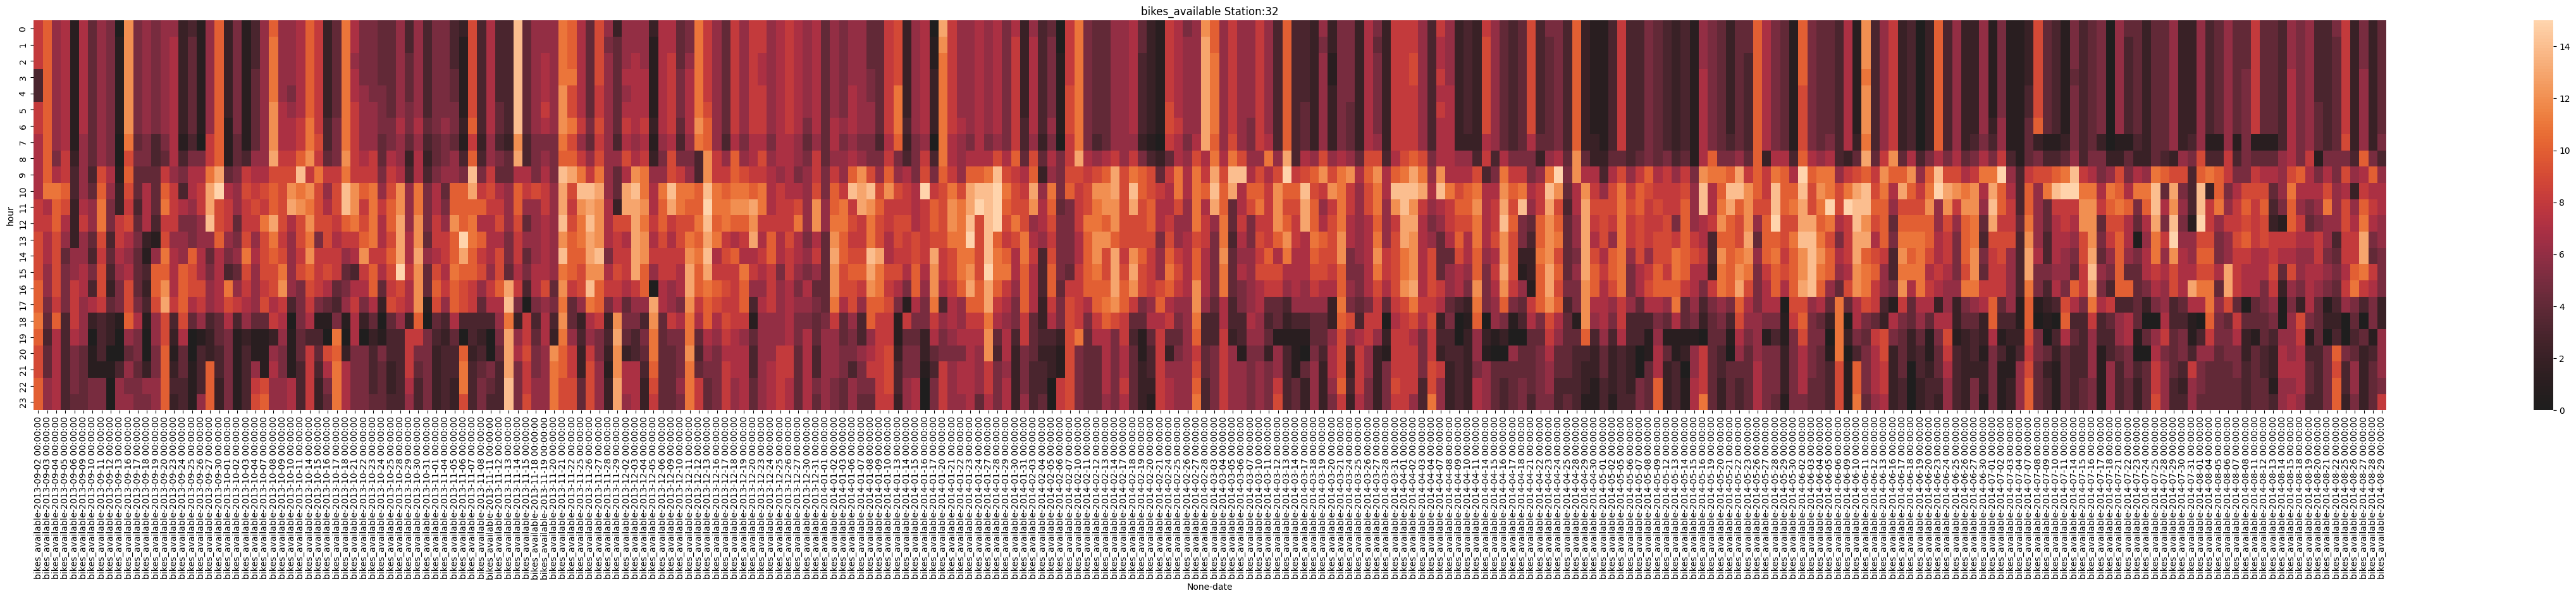

In [145]:
# ステーションごとに２４時間の差分。
sta = 32
input_result = input
input_result['bikes_available_predict'] = input_predict
input_result['predict_diff'] = input_result['bikes_available_predict'] - input_result['bikes_available']
input_result['predict_deltaAt0'] = input_result['bikes_available_at0'] - input_result['bikes_available_predict']

# 対象のステーションと曜日を絞る
input_result = input_result[input_result['station_id']==sta]
input_result = input_result[input_result['weekday'] < 5]

deltaAt0 = input_result[['date','hour','deltaAt0']]
deltaAt0 = pd.pivot_table(data=deltaAt0, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(deltaAt0, center = 0)
p.set_title("deltaAt0 Station:" + str(sta))

predict_deltaAt0 = input_result[['date','hour','predict_deltaAt0']]
predict_deltaAt0 = pd.pivot_table(data=predict_deltaAt0, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(predict_deltaAt0, center = 0)
p.set_title("predict_deltaAt0 Station:" + str(sta))

predict_diff = input_result[['date','hour','predict_diff']]
predict_diff = pd.pivot_table(data=predict_diff, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(predict_diff, center = 0)
p.set_title("predict_diff Station:" + str(sta))

available_predict = input_result[['date','hour','bikes_available_predict']]
available_predict = pd.pivot_table(data=available_predict, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(available_predict, center = 0)
p.set_title("bikes_available_predict Station:" + str(sta))

bikes_available = input_result[['date','hour','bikes_available']]
bikes_available = pd.pivot_table(data=bikes_available, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(bikes_available, center = 0)
p.set_title("bikes_available Station:" + str(sta))



C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\1881220572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_station['bikes_available_diff'] = target_station['bikes_available_predict'] - target_station['bikes_available']


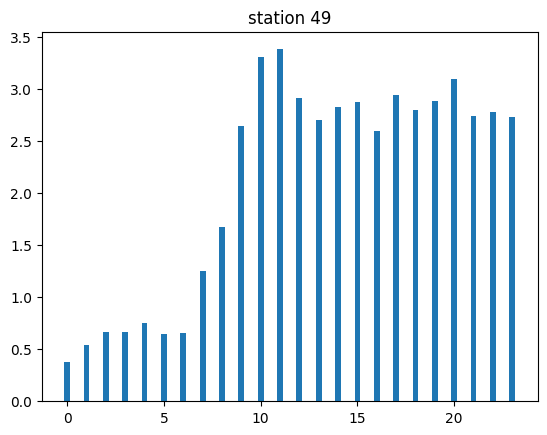

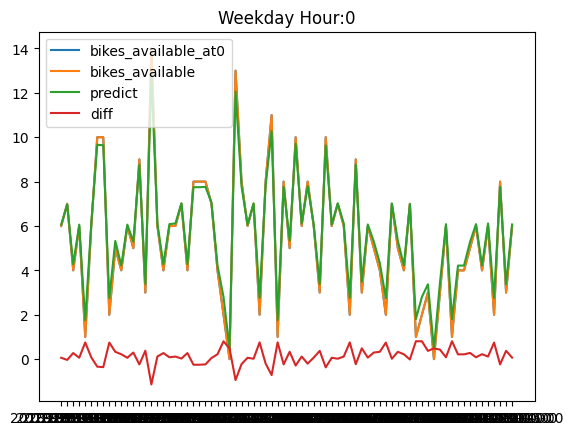

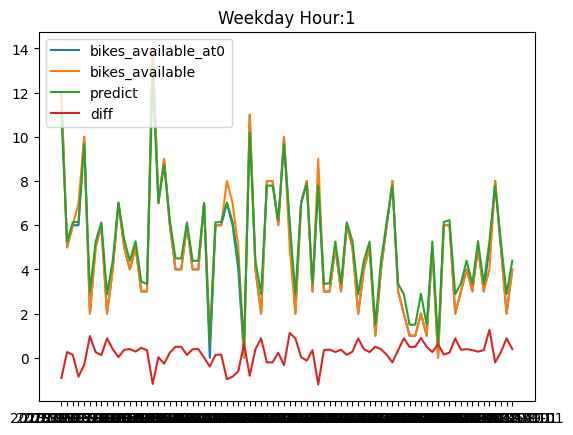

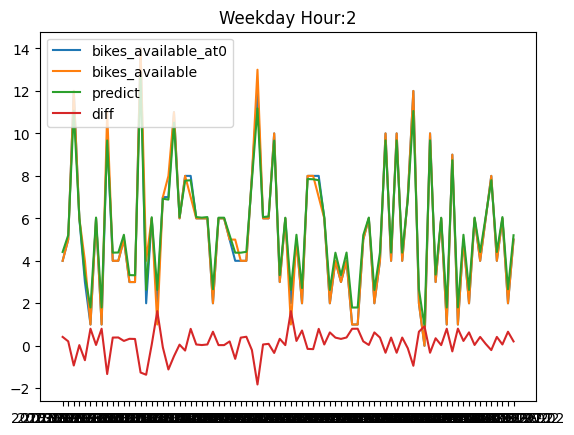

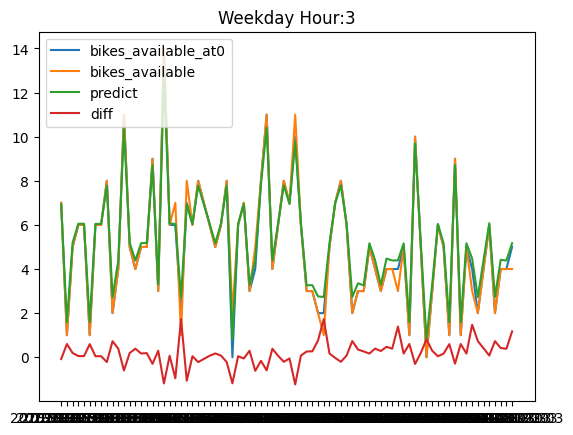

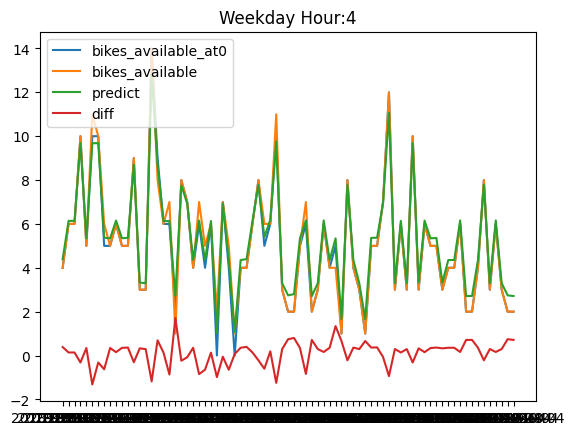

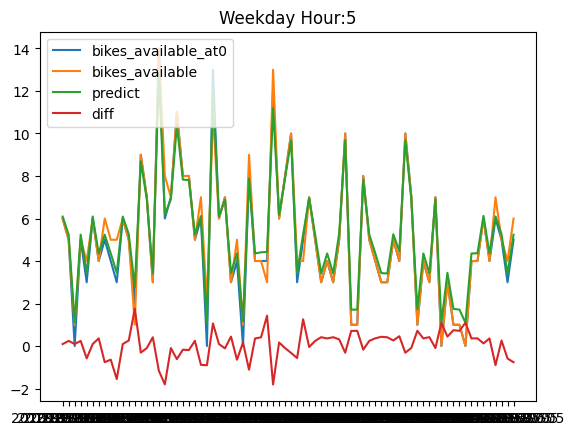

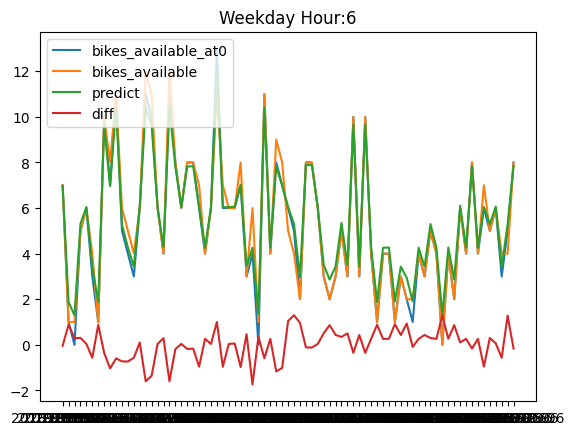

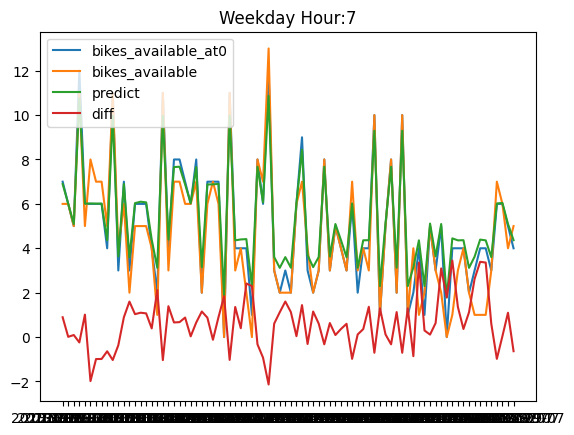

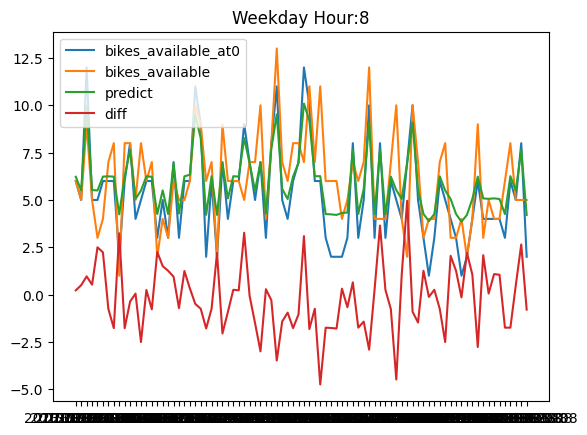

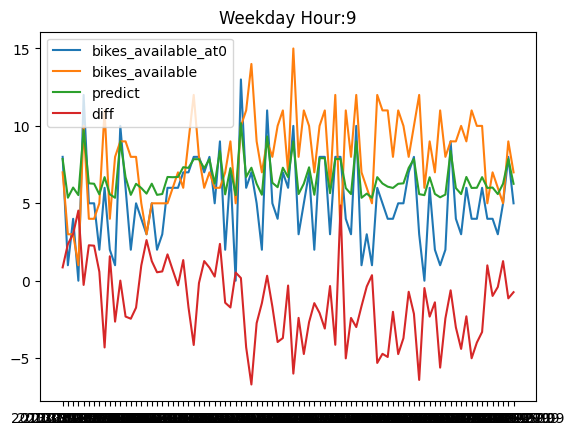

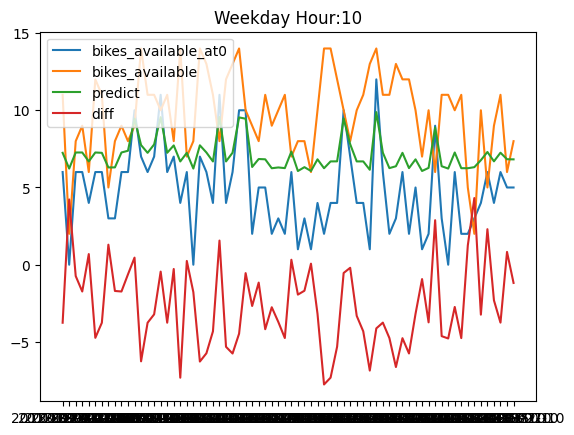

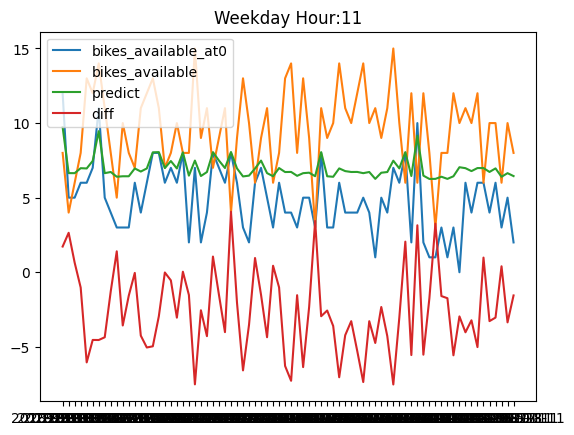

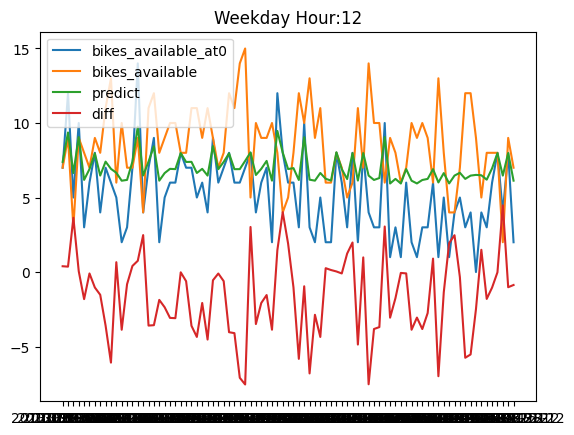

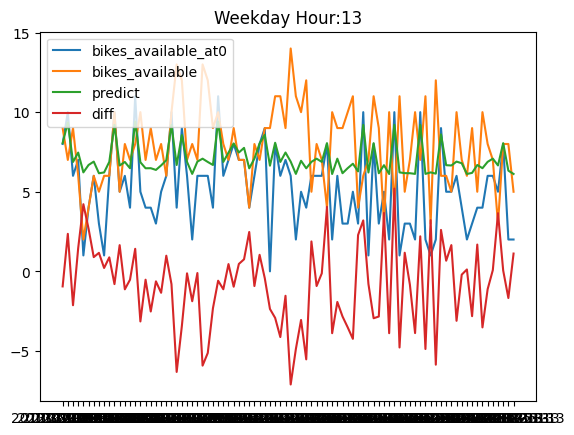

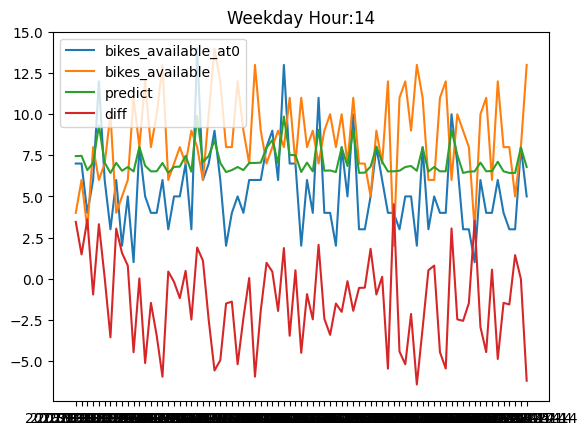

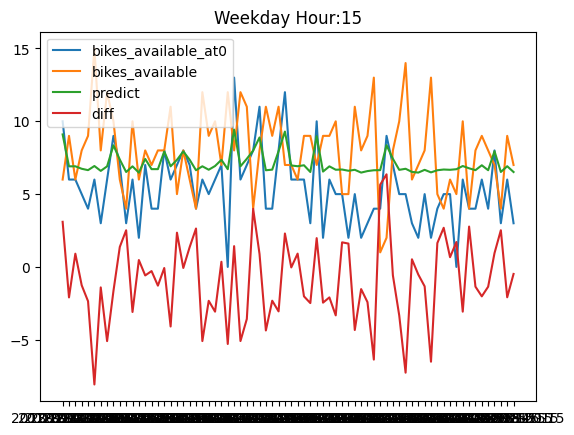

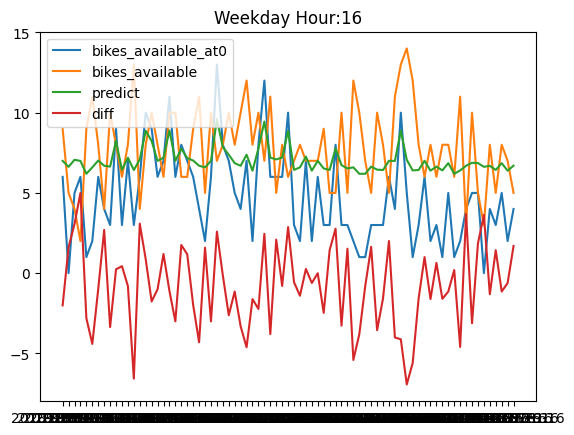

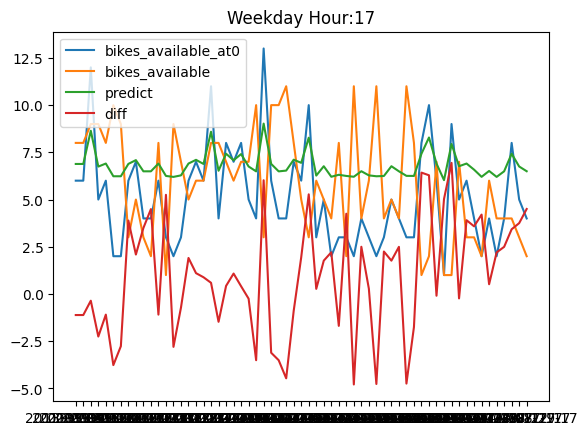

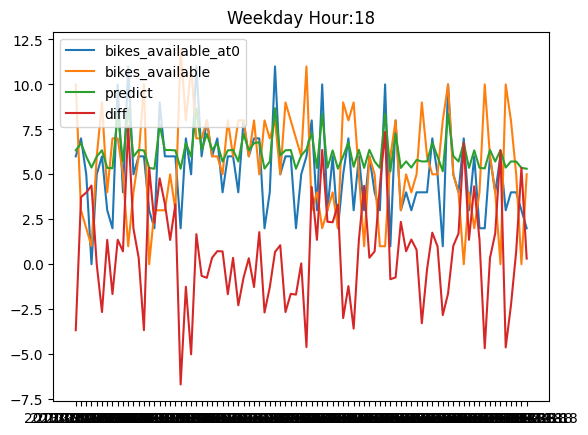

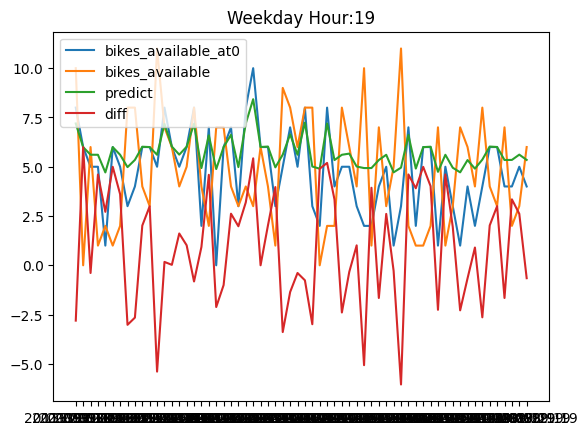

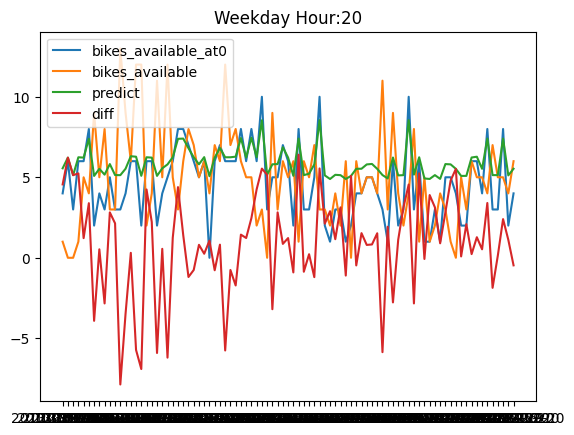

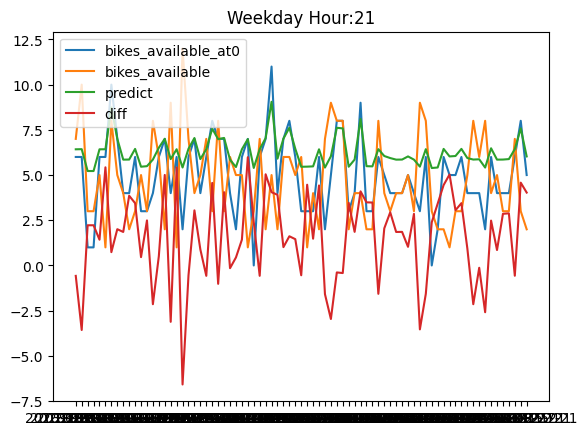

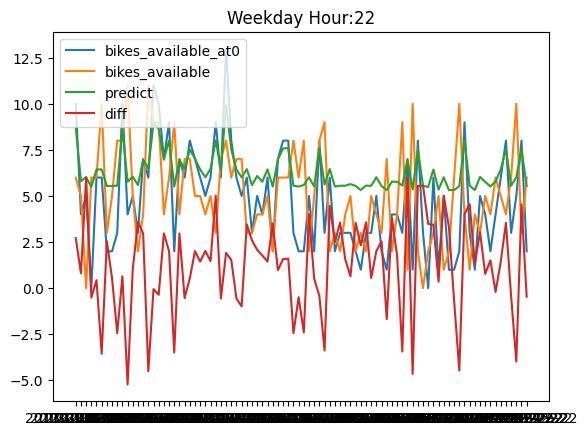

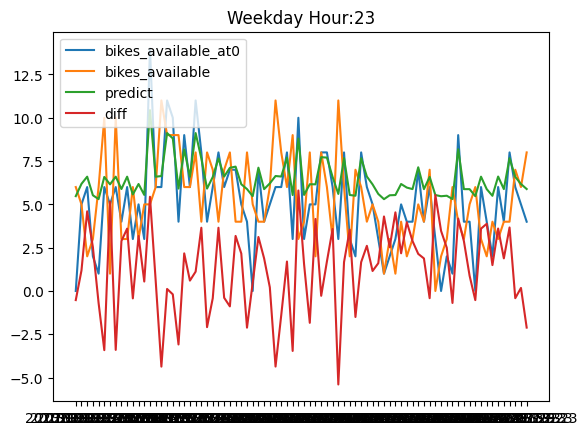

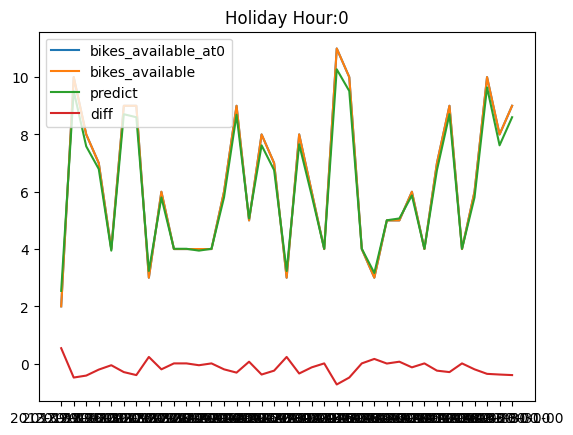

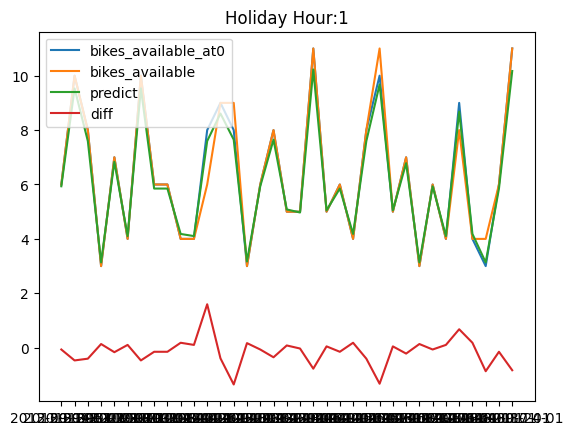

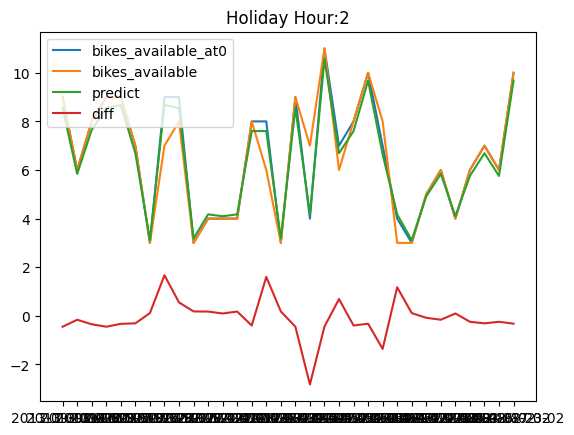

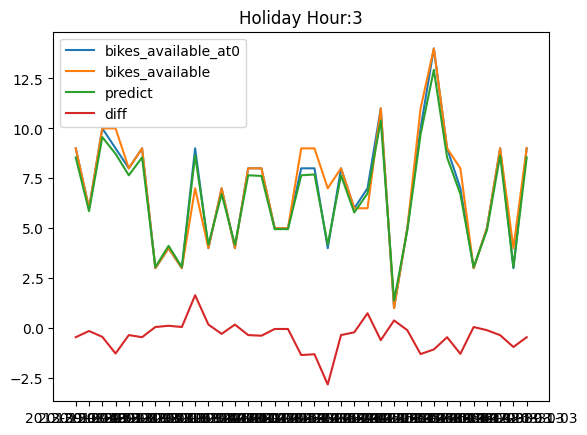

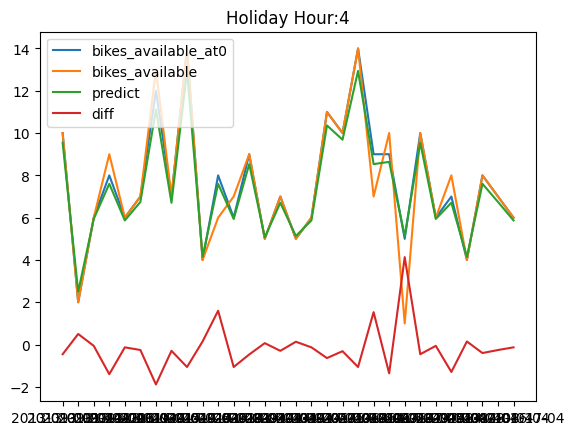

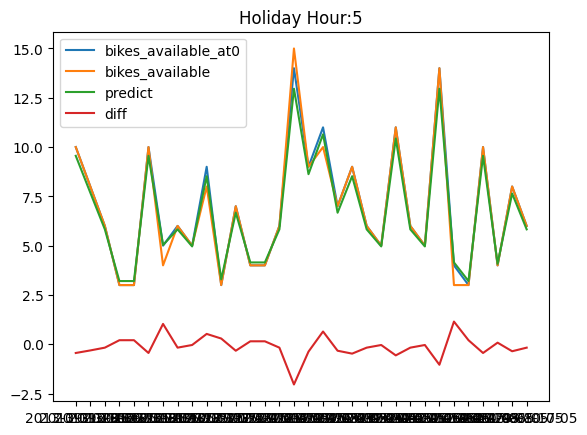

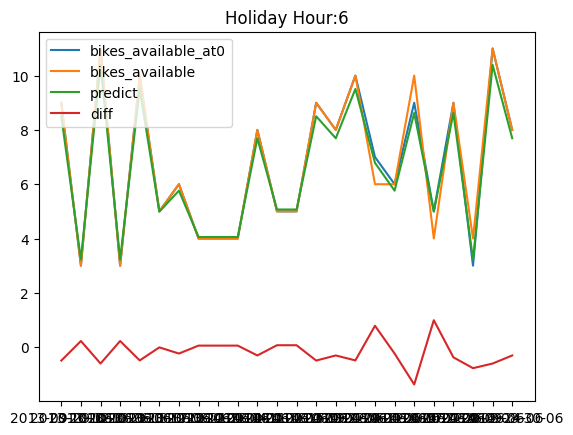

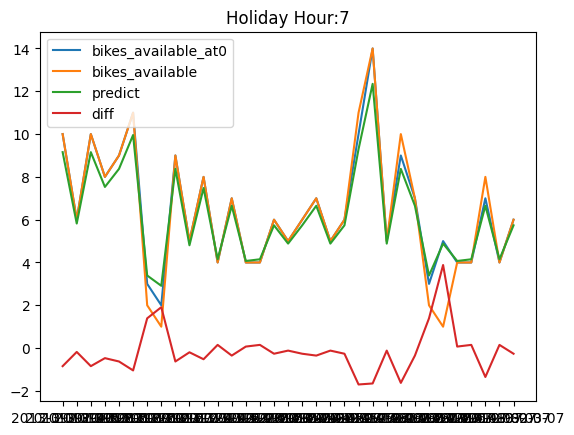

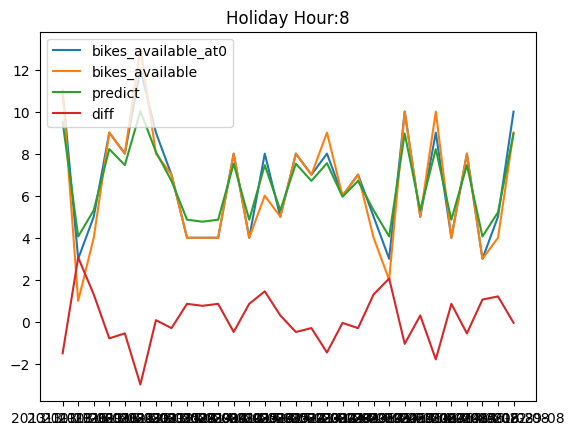

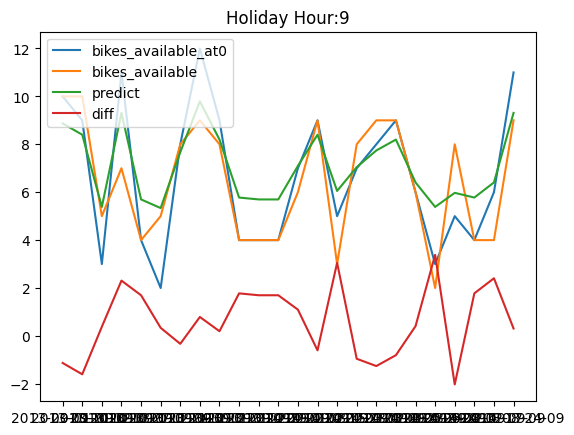

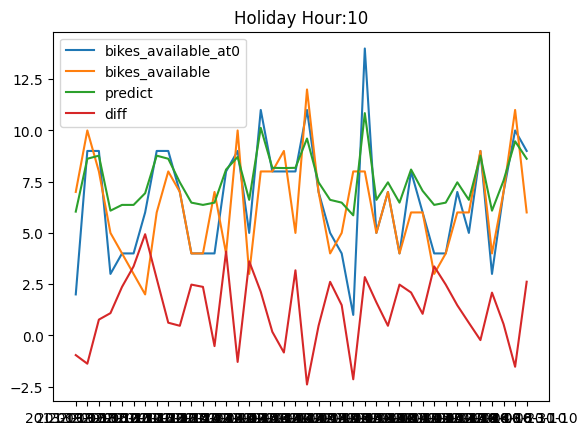

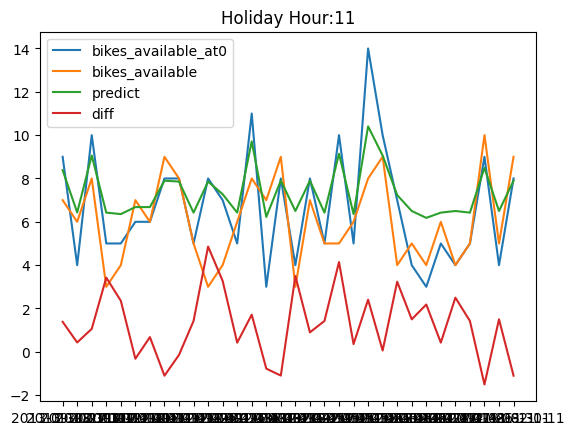

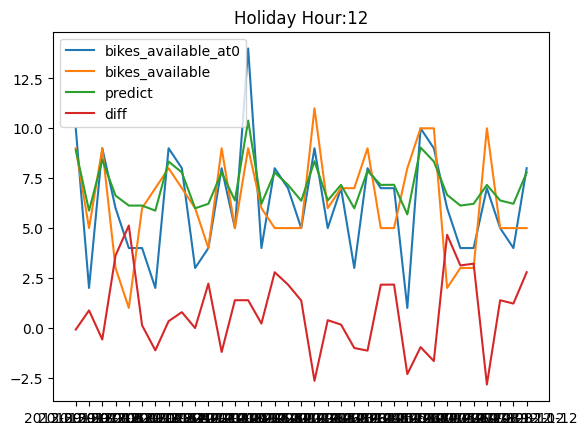

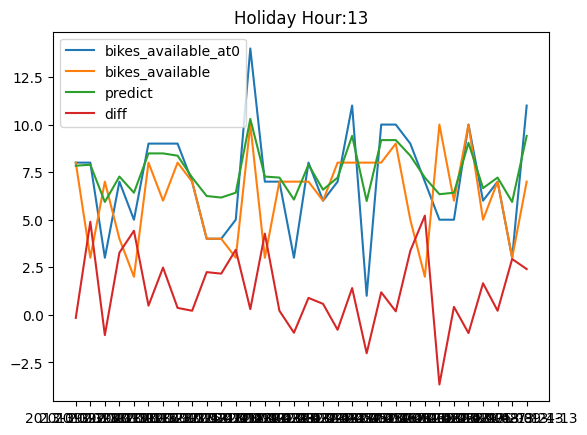

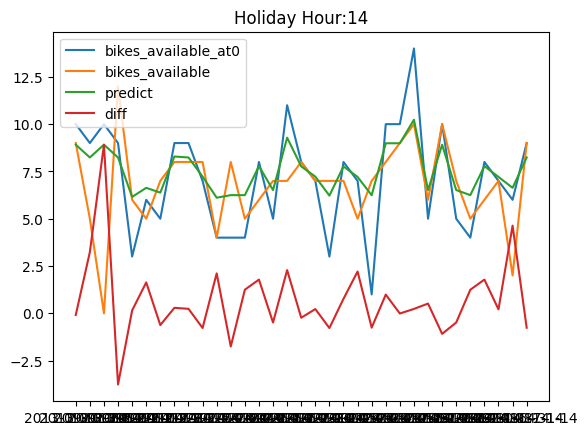

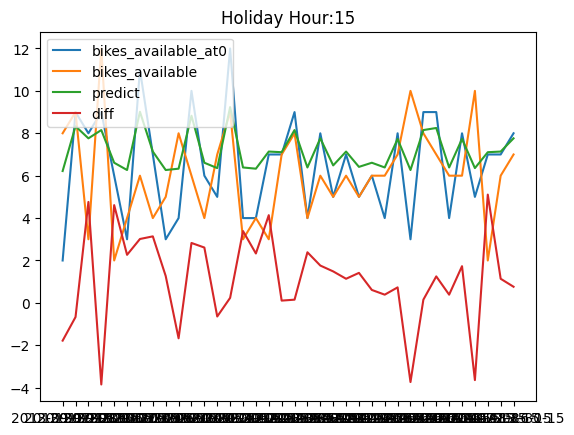

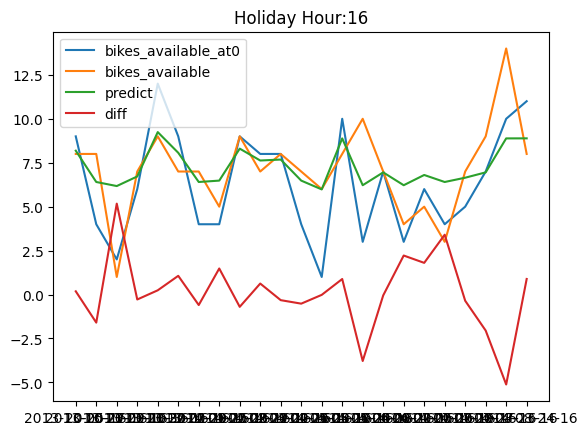

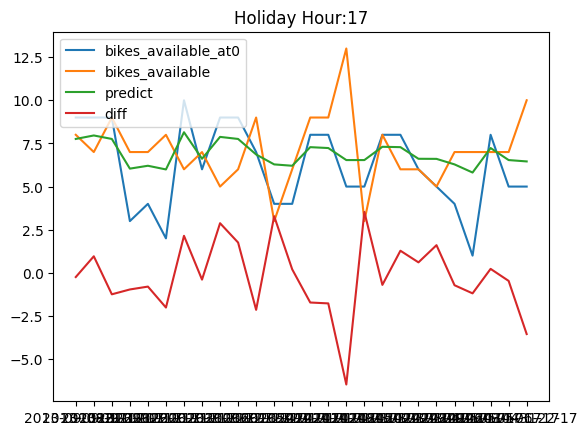

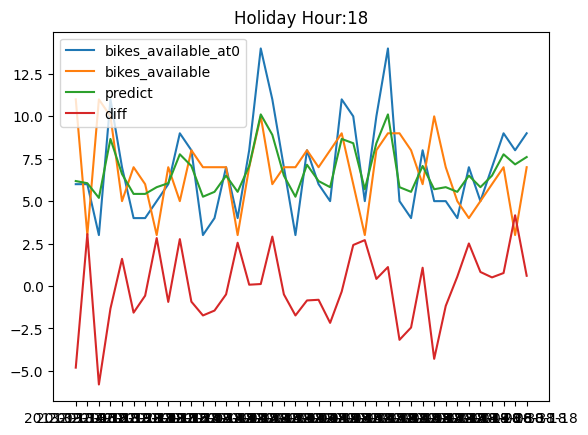

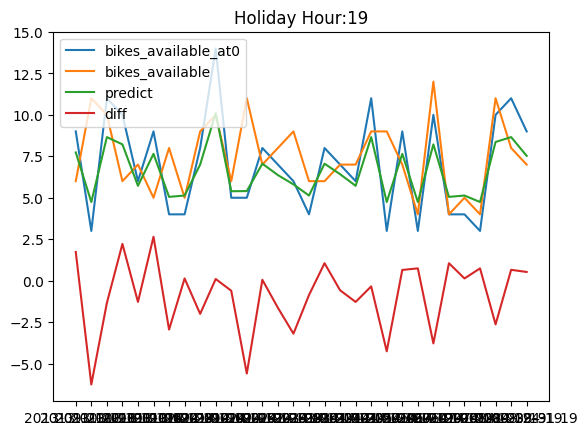

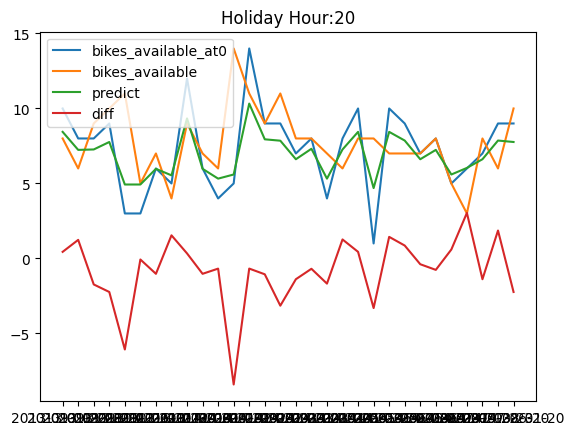

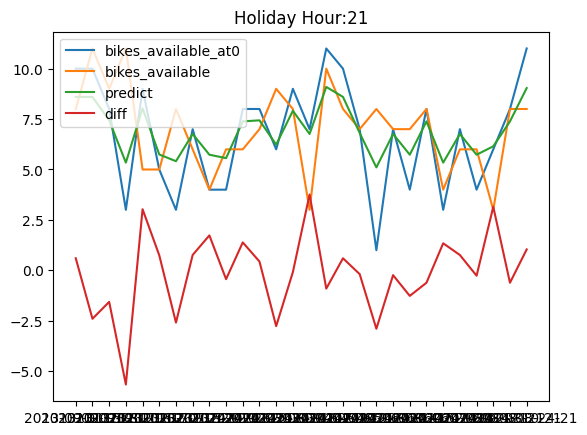

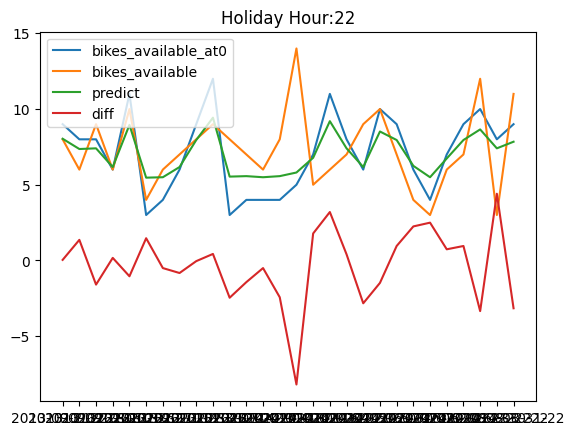

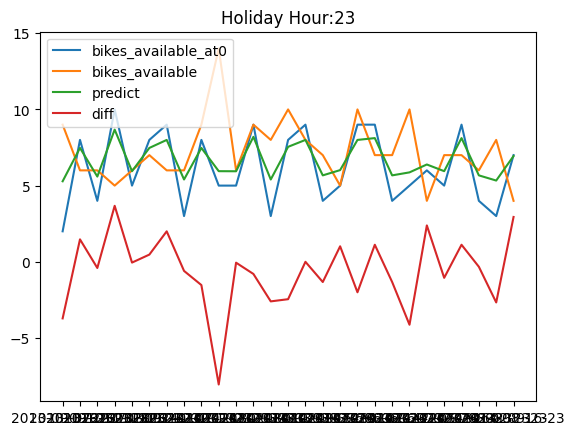

In [146]:
# ステーションごとの差分が分析できてないイメージか。
# 差が大きいステーション49を詳しく見てみる
target_station = valid_predict[valid_predict['station_id'] == 32]
# 予測と実際の差分
target_station['bikes_available_diff'] = target_station['bikes_available_predict'] - target_station['bikes_available']
target_station = target_station.sort_values('date_hour')

# 時間ごとのRMSEの差分
rmse_by_target1 = []
for i in range(0, 24):
    temp1 = target_station[target_station['hour'] == i]
    if len(temp1) > 0:
        rmse_by_target1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_target1.append(0)
plt.bar(range(0, 24), rmse_by_target1, width=0.3, label='valid')
plt.title("station 49")
plt.show()

for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] < 5]
    p0 = plt.plot(target['date_hour'], target['bikes_available_at0'], linestyle="solid")
    p1 = plt.plot(target['date_hour'], target['bikes_available'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_available_predict'], linestyle="solid")
    p3 = plt.plot(target['date_hour'], target['bikes_available_diff'], linestyle="solid")
    plt.title("Weekday Hour:" + str(i))
    plt.legend((p0[0], p1[0], p2[0], p3[0]), ("bikes_available_at0", "bikes_available", "predict", "diff"), loc=2)
    plt.show()

for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] > 4]
    p0 = plt.plot(target['date_hour'], target['bikes_available_at0'], linestyle="solid")
    p1 = plt.plot(target['date_hour'], target['bikes_available'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_available_predict'], linestyle="solid")
    p3 = plt.plot(target['date_hour'], target['bikes_available_diff'], linestyle="solid")
    plt.title("Holiday Hour:" + str(i))
    plt.legend((p0[0], p1[0], p2[0], p3[0]), ("bikes_available_at0", "bikes_available", "predict", "diff"), loc=2)
    plt.show()

C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\4279040392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_station['bikes_used'] = target_station['bikes_available_at0'] - target_station['bikes_available']
C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\4279040392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_station['bikes_used_predict'] = target_station['bikes_available_at0'] - target_station['bikes_available_predict']
C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\4279

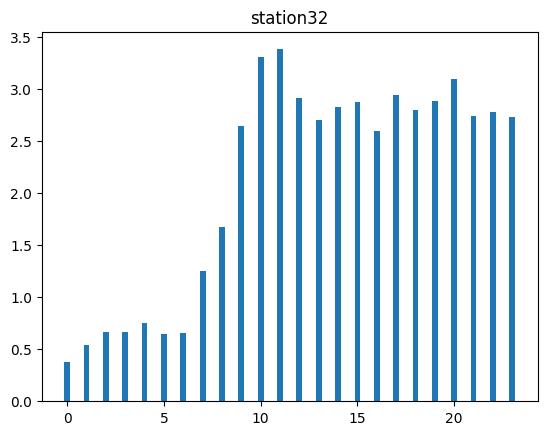

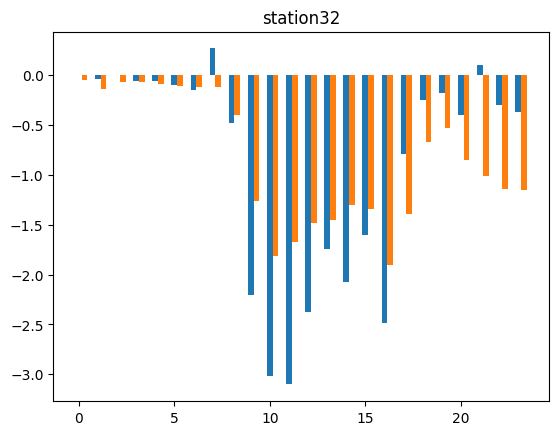

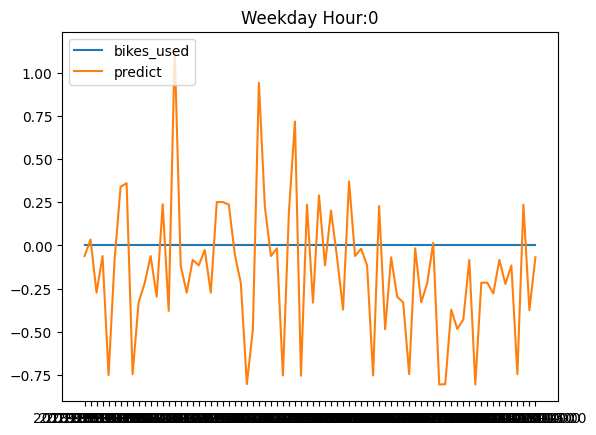

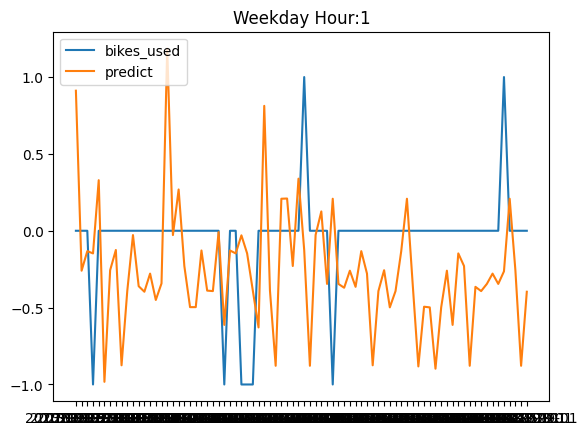

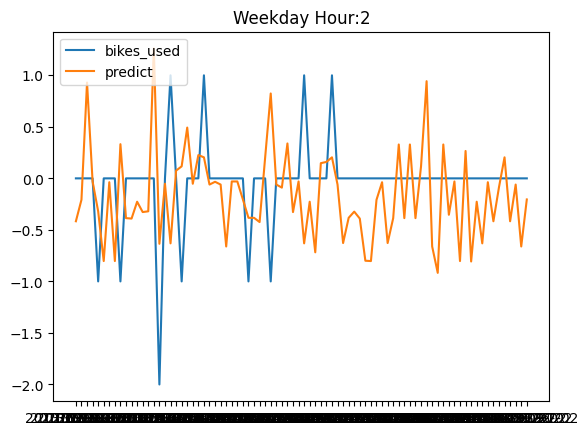

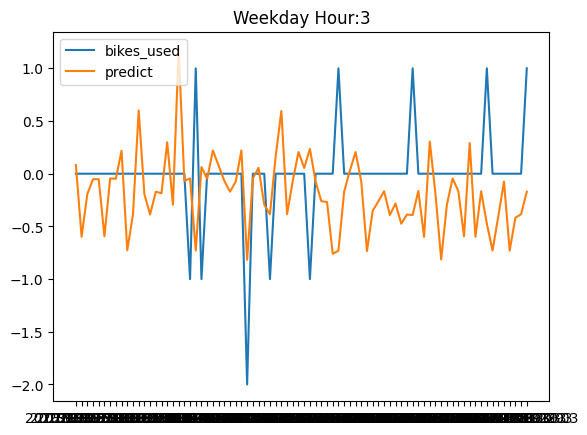

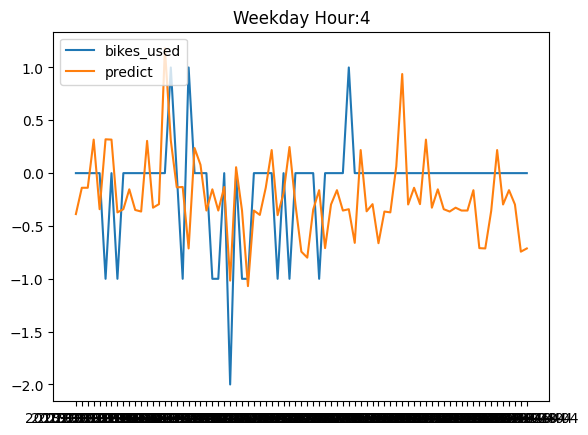

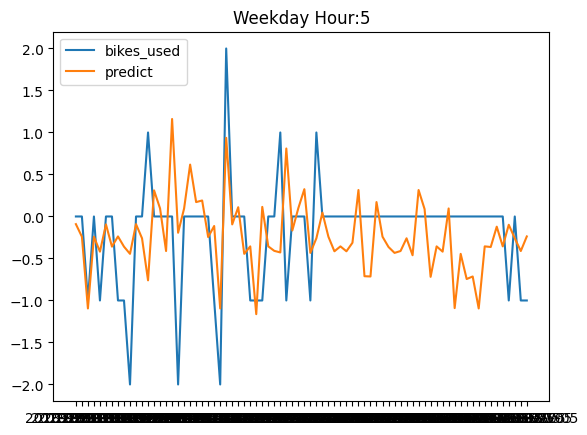

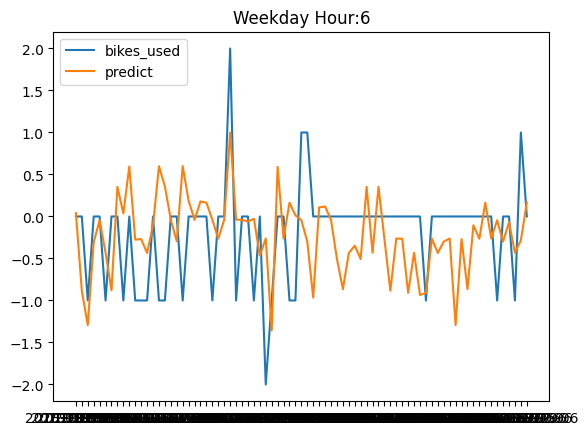

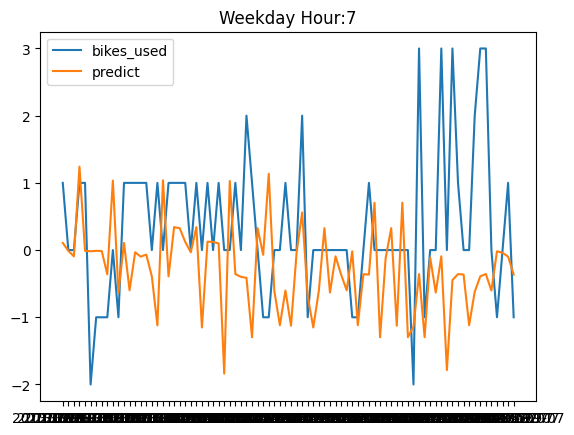

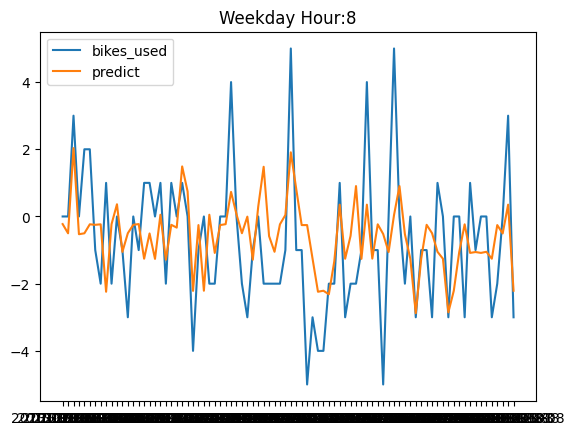

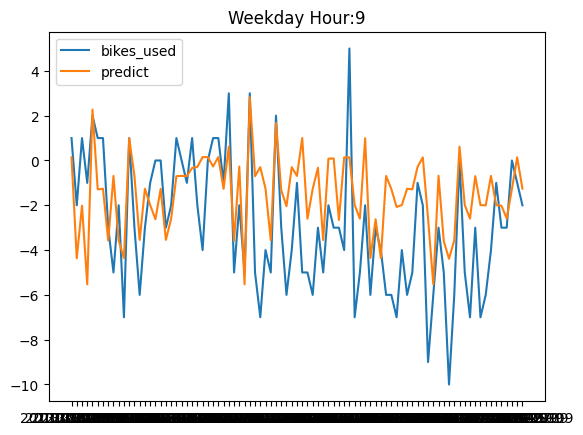

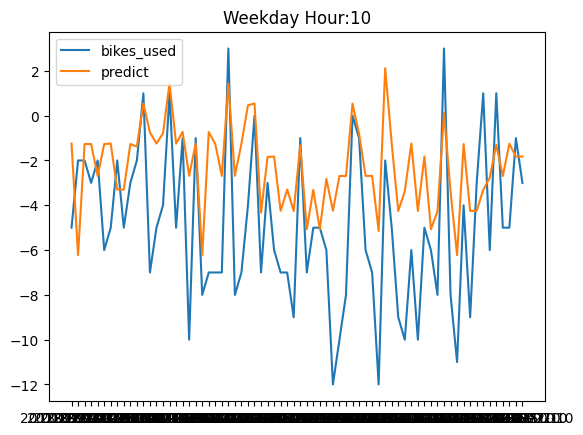

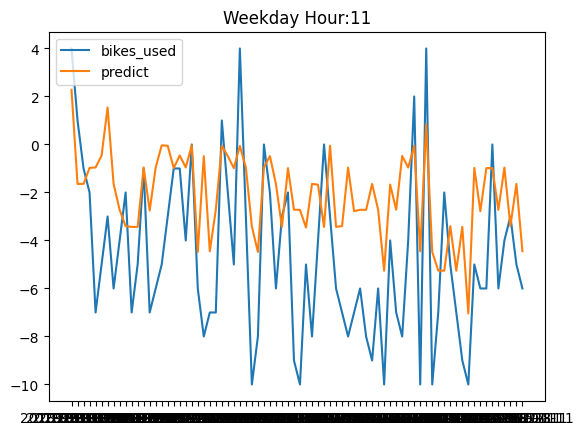

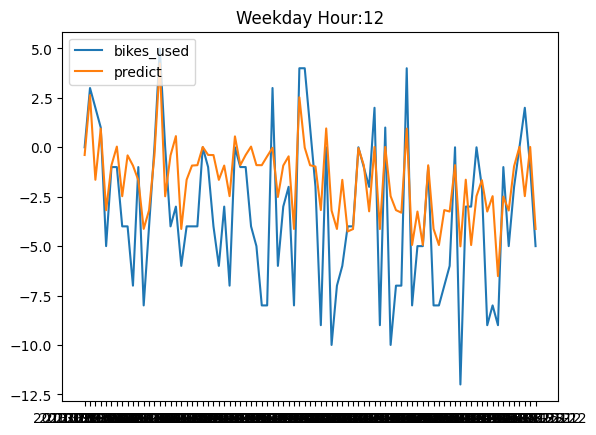

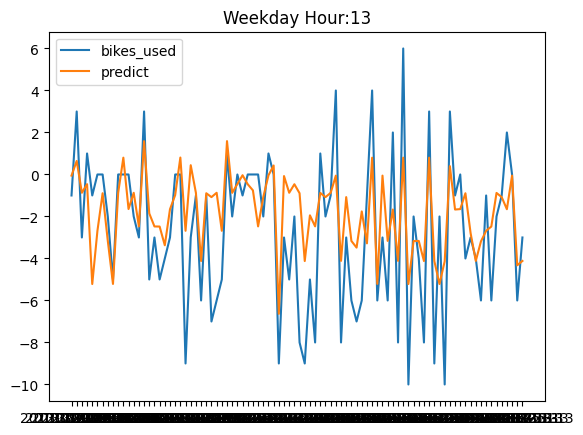

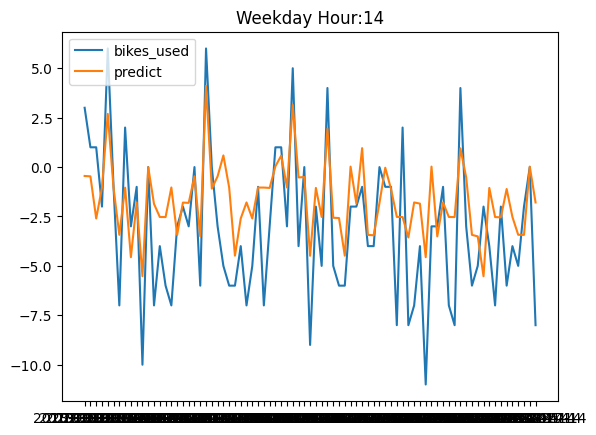

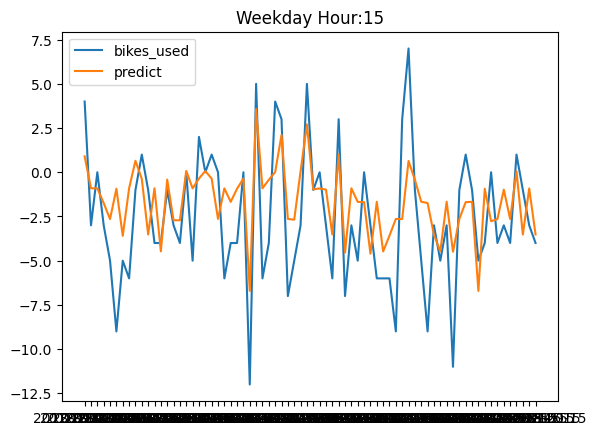

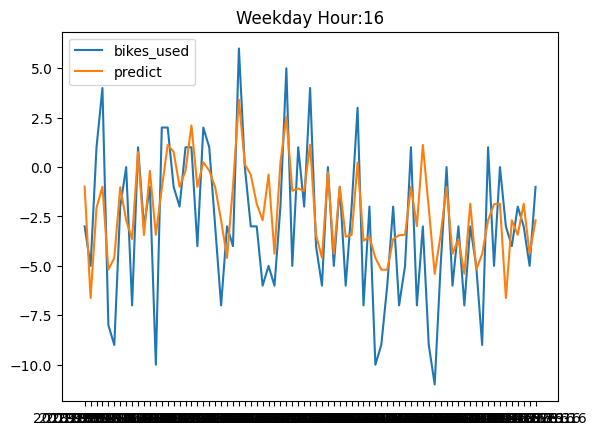

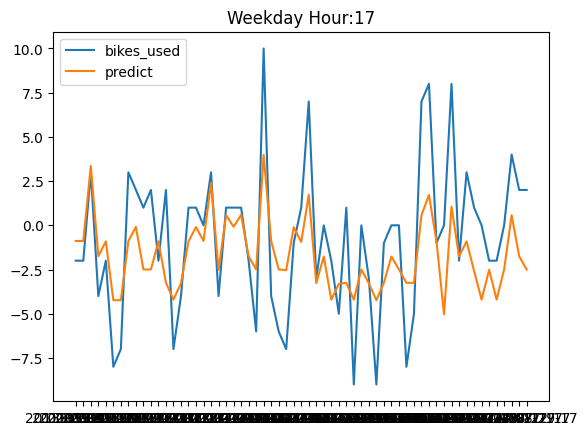

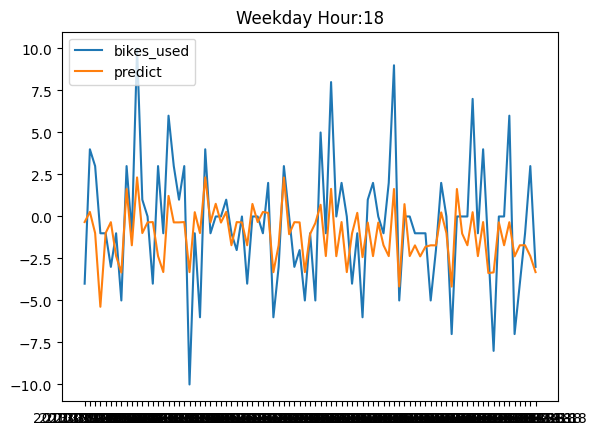

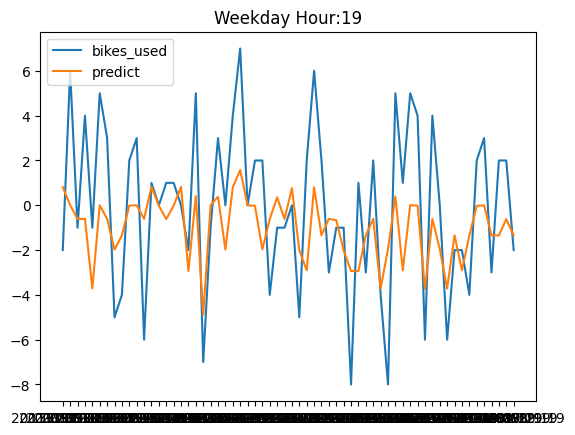

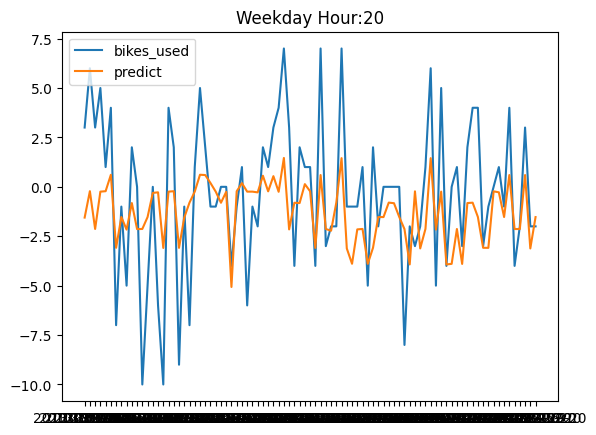

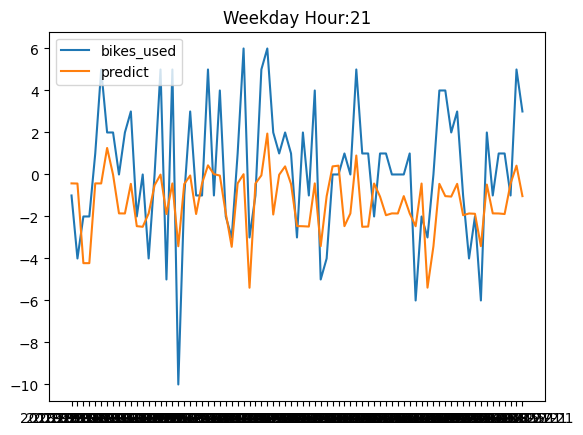

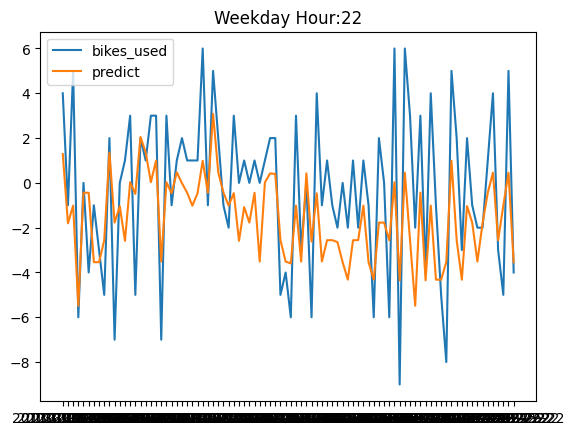

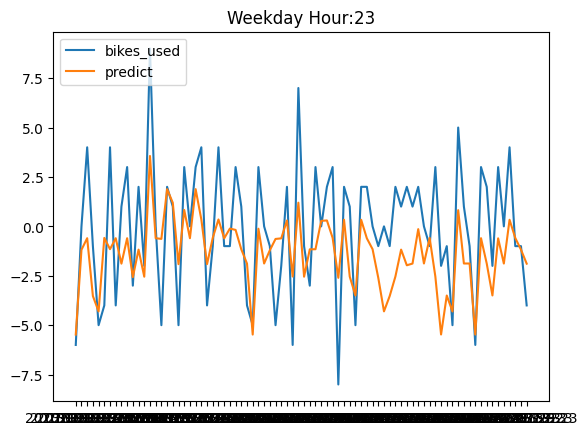

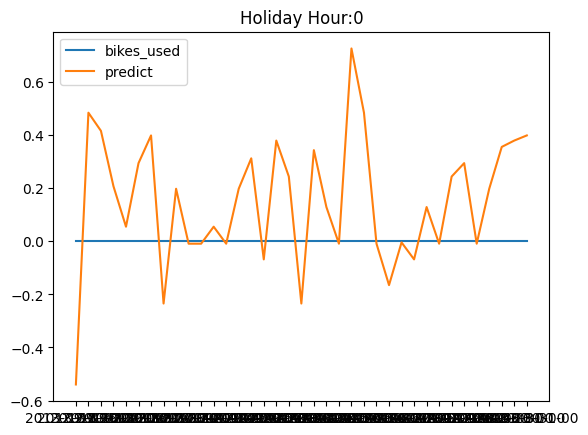

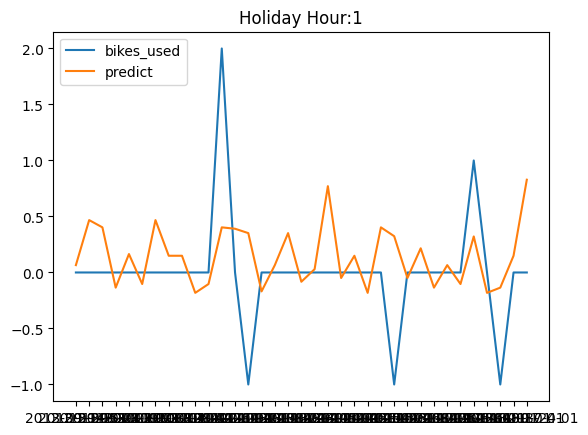

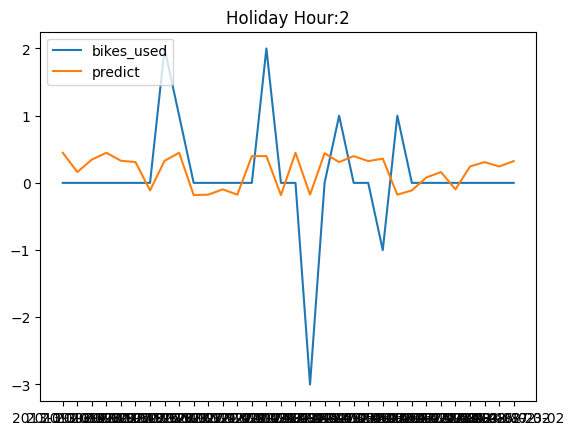

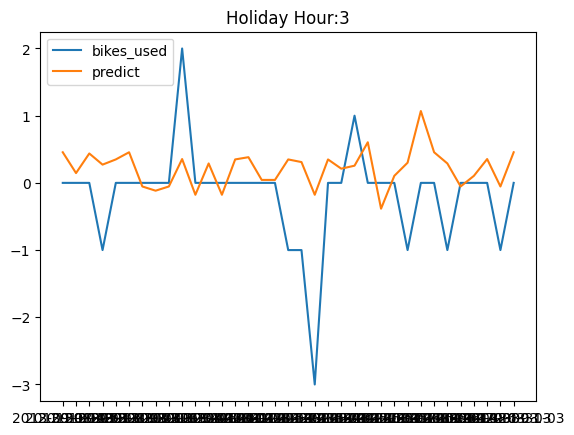

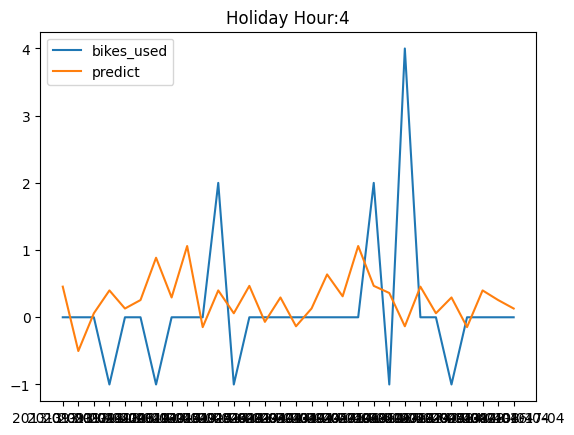

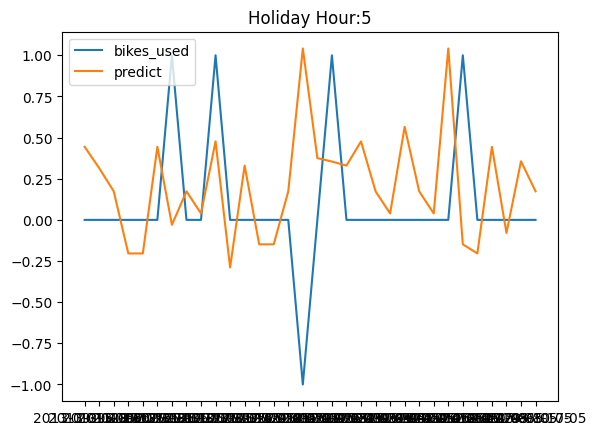

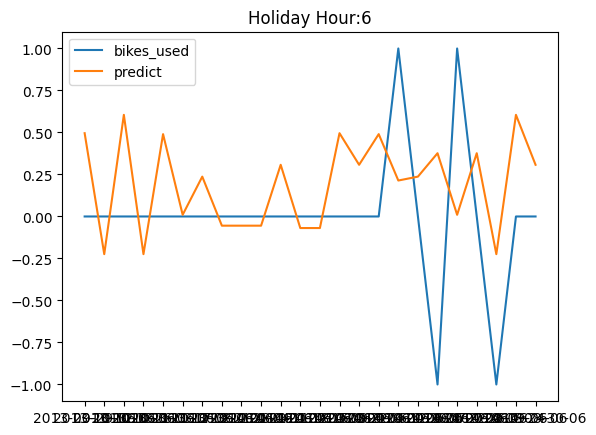

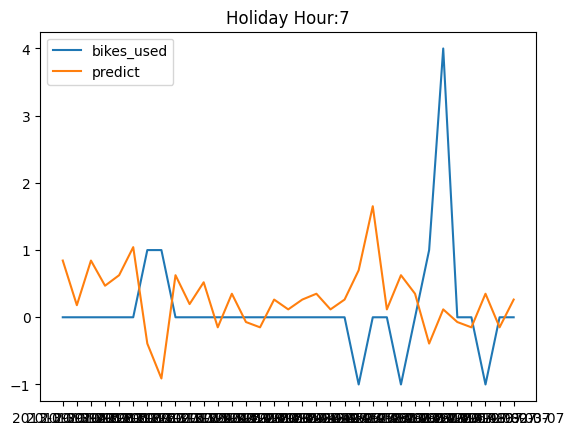

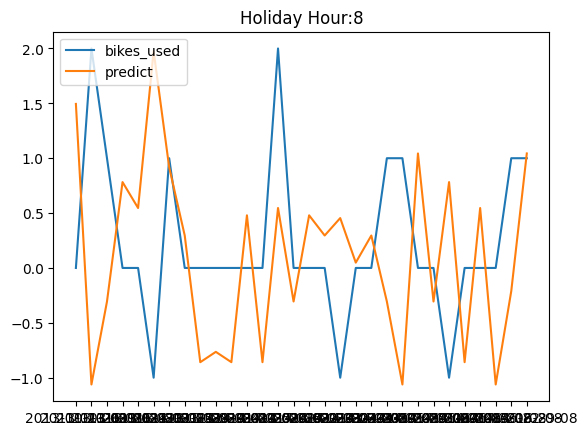

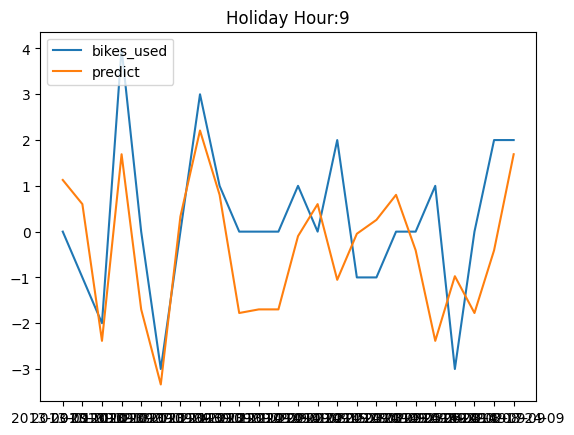

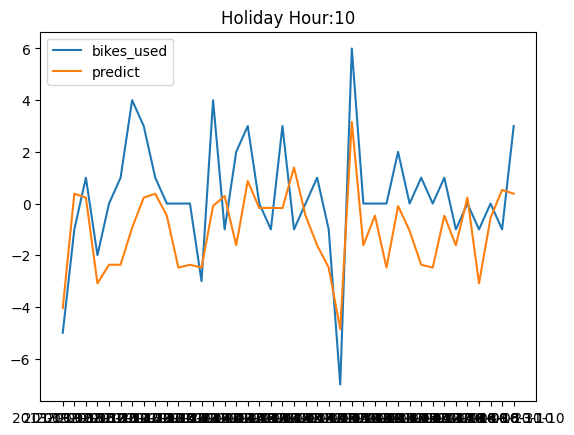

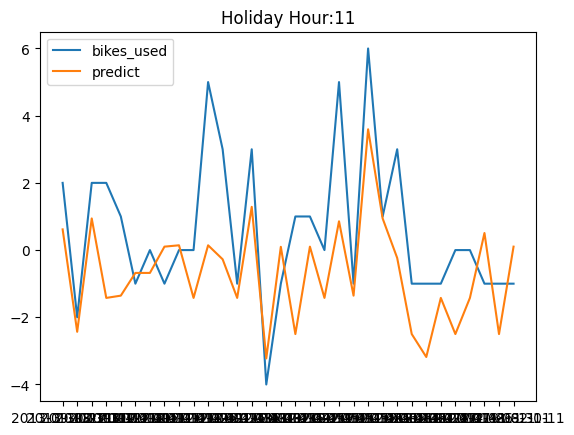

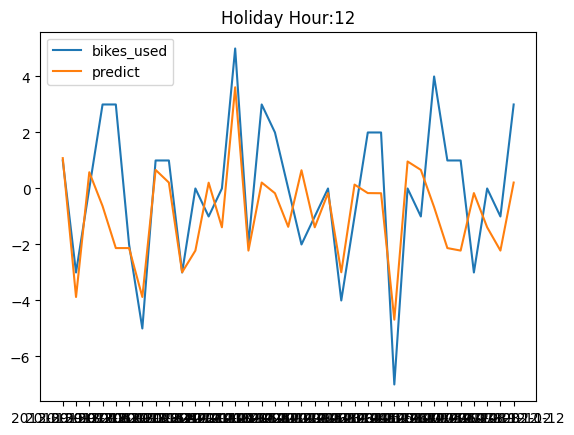

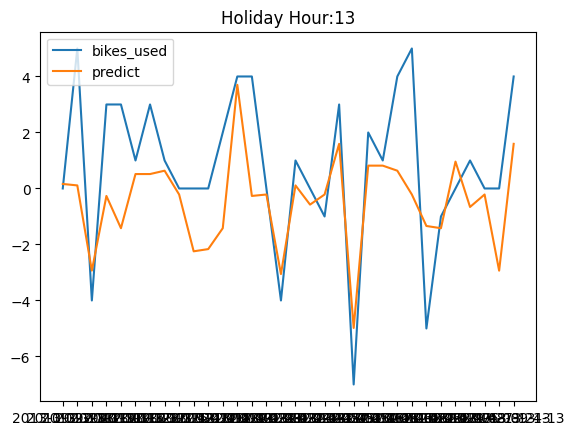

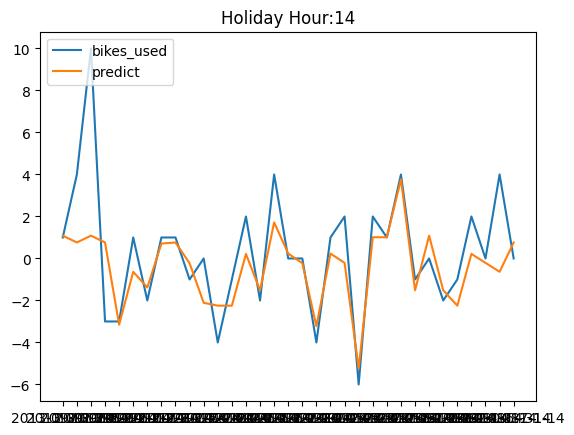

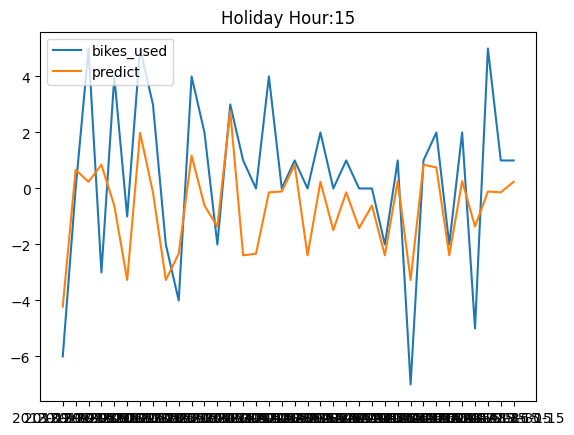

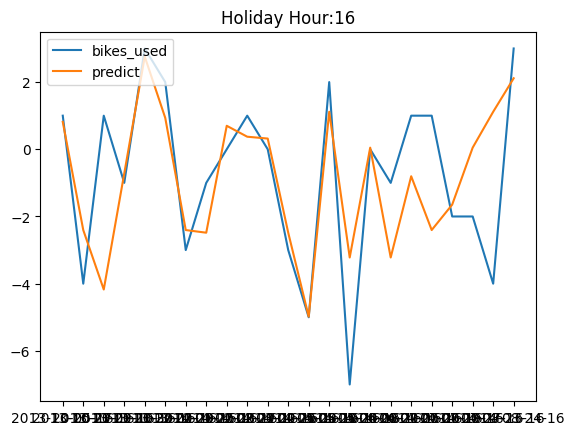

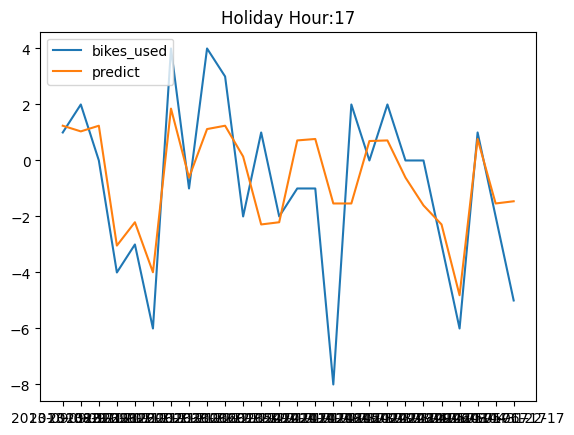

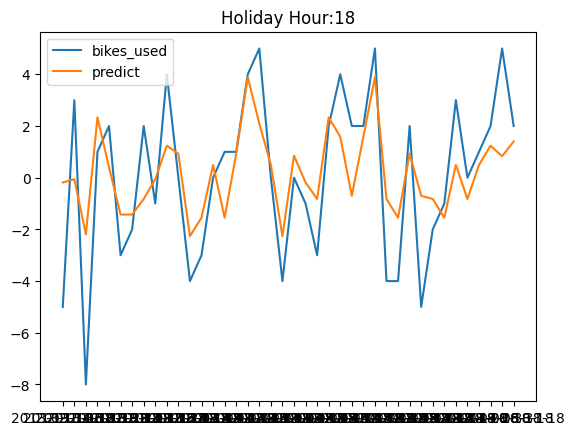

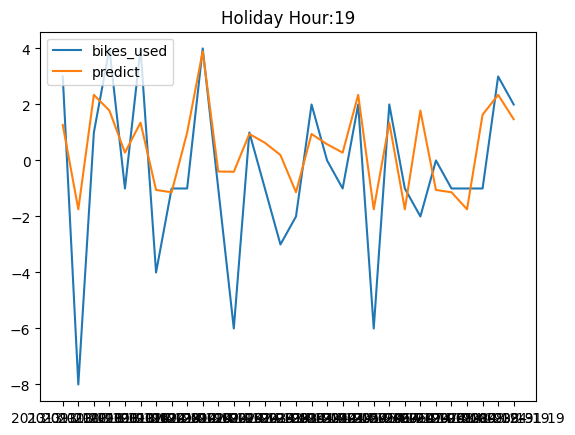

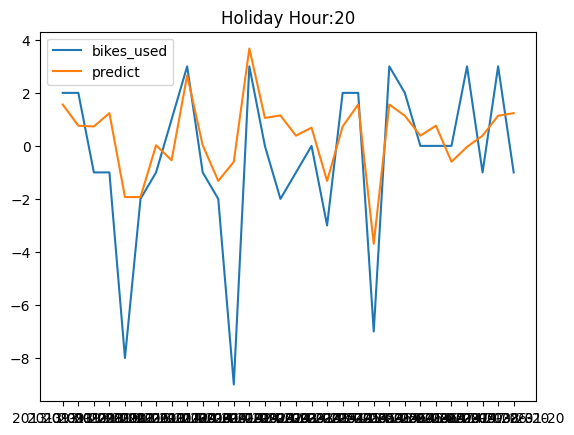

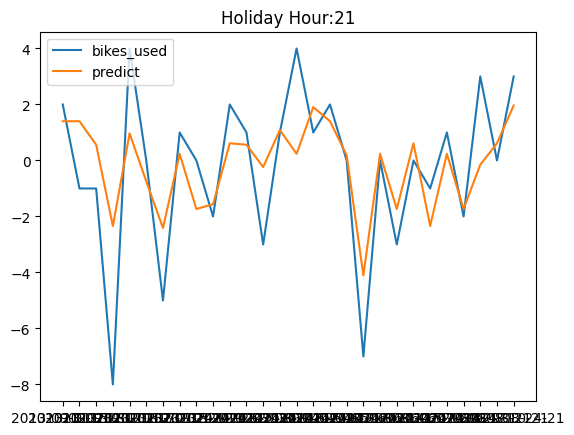

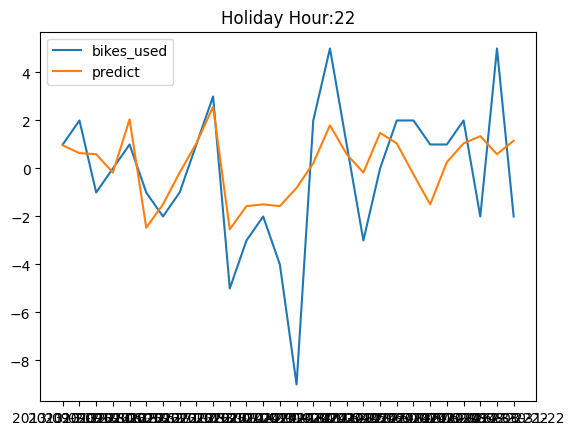

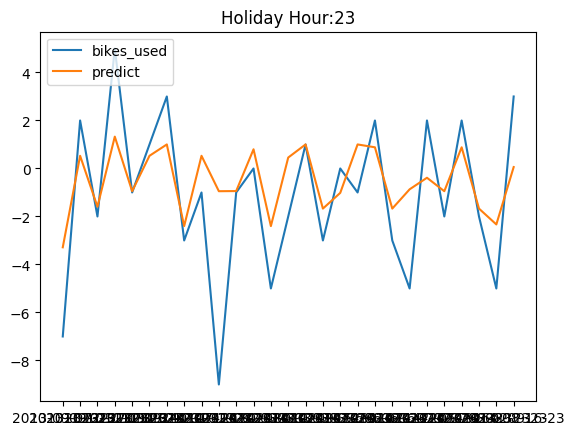

In [147]:
# ステーションごとの差分が分析できてないイメージか。
# 差が大きいステーション49を詳しく見てみる
sta = 32
target_station = valid_predict[valid_predict['station_id'] == sta]
# 予測と実際の差分
target_station['bikes_used'] = target_station['bikes_available_at0'] - target_station['bikes_available']
target_station['bikes_used_predict'] = target_station['bikes_available_at0'] - target_station['bikes_available_predict']
target_station['bikes_used_diff'] = target_station['bikes_used_predict'] - target_station['bikes_used']
target_station = target_station.sort_values('date_hour')

# 時間ごとのRMSEの差分
rmse_by_target1 = []
for i in range(0, 24):
    temp1 = target_station[target_station['hour'] == i]
    if len(temp1) > 0:
        rmse_by_target1.append(mean_squared_error(temp1['bikes_used'], temp1['bikes_used_predict'], squared=False))
    else:
        rmse_by_target1.append(0)
plt.bar(range(0, 24), rmse_by_target1, width=0.3, label='valid')
plt.title("station" + str(sta))
plt.show()

# 時間ごとの値の平均
mean_by_target1 = []
mean_by_target2 = []
for i in range(0, 24):
    temp1 = target_station[target_station['hour'] == i]
    if len(temp1) > 0:
        mean_by_target1.append(temp1['bikes_used'].mean())
        mean_by_target2.append(temp1['bikes_used_predict'].mean())
    else:
        mean_by_target1.append(0)
        mean_by_target2.append(0)
plt.bar(range(0, 24), mean_by_target1, width=0.3, label='available_mean')
plt.bar(np.array(range(0, 24)) + 0.3, mean_by_target2, width=0.3, label='predict_mean')
plt.title("station" + str(sta))
plt.show()


for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] < 5]
    p1 = plt.plot(target['date_hour'], target['bikes_used'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_used_predict'], linestyle="solid")
    plt.title("Weekday Hour:" + str(i))
    plt.legend((p1[0], p2[0]), ("bikes_used", "predict"), loc=2)
    plt.show()

for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] > 4]
    p1 = plt.plot(target['date_hour'], target['bikes_used'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_used_predict'], linestyle="solid")
    plt.title("Holiday Hour:" + str(i))
    plt.legend((p1[0], p2[0]), ("bikes_used", "predict"), loc=2)
    plt.show()

39765 49920
90956 109200
16974 21840
16531 21840
13234 15600


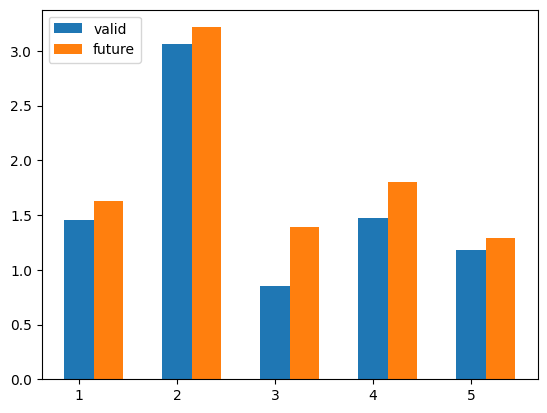

In [148]:
# cityごとのRMSEの差分
rmse_by_city1 = []
rmse_by_city2 = []
for i in range(1, 6):
    temp1 = valid_predict[valid_predict['city'] == 'city' + str(i)]
    rmse_by_city1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    temp2 = valid_predict2[valid_predict2['city'] == 'city' + str(i)]
    rmse_by_city2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    print(len(temp1), len(temp2))
plt.bar(range(1, 6), rmse_by_city1, width=0.3, label='valid')
plt.bar(np.array(range(1, 6)) + 0.3, rmse_by_city2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()
